# Precificação de Veículos Seminovos com Machine Learning

Queremos construir um modelo para **estimar o preço de venda (`sale_price`) de carros usados na Índia**, usando atributos como ano de fabricação, quilometragem, marca, modelo, etc.

Para evitar modelos com pouquíssimos exemplos, vamos **restringir o dataset** apenas aos modelos de carro (`model`) que aparecem **pelo menos 100 vezes**. Assim, o modelo aprende melhor e nossas conclusões valem apenas para esses modelos mais comuns.


## 1. Carga, recorte e visão inicial

Carregamos o CSV, aplicamos o recorte para manter apenas modelos com ≥100 ocorrências (evita classes raras) e configuramos o ambiente de plots. Objetivo: começar com um dataset enxuto e consistente para as análises seguintes.

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from google.colab import drive
import missingno as msno



# Configuração básica de gráficos
plt.style.use("default")
sns.set(rc={"figure.figsize": (10, 5)})

# 1) Carregar dataset original
df_raw = pd.read_csv("Used_Car_Price_Prediction.csv")

print("Shape original:", df_raw.shape)

# 2) Manter apenas modelos com pelo menos 100 ocorrências
model_counts = df_raw["model"].value_counts()
models_to_keep = model_counts[model_counts >= 100].index

df = df_raw[df_raw["model"].isin(models_to_keep)].copy()

print("Shape após recorte por modelo:", df.shape)
print(f"Proporção de linhas mantidas: {len(df) / len(df_raw):.2%}")


Shape original: (7400, 29)
Shape após recorte por modelo: (5316, 29)
Proporção de linhas mantidas: 71.84%


## 2. Visão geral inicial

Mostramos amostras (`head`), `info()` e estatísticas numéricas para entender tipos, faixas de valores e possíveis extremos antes de qualquer transformação.

In [89]:
print("Primeiras 5 linhas do dataset filtrado:")
display(df.head())

print("\nInformações gerais (types, não nulos):")
df.info()


Primeiras 5 linhas do dataset filtrado:


,car_name,yr_mfr,fuel_type,kms_run,sale_price,city,times_viewed,body_type,transmission,variant,...,total_owners,broker_quote,original_price,car_rating,ad_created_on,fitness_certificate,emi_starts_from,booking_down_pymnt,reserved,warranty_avail
0,maruti swift,2015,petrol,8063,386399,noida,18715,hatchback,manual,lxi opt,...,2,397677,404177.0,great,2021-04-04T07:09:18.583,True,8975,57960,False,False
1,maruti alto 800,2016,petrol,23104,265499,noida,2676,hatchback,manual,lxi,...,1,272935,354313.0,great,2021-03-22T14:07:32.833,True,6167,39825,False,False
2,hyundai grand i10,2017,petrol,23402,477699,noida,609,hatchback,manual,sports 1.2 vtvt,...,1,469605,NaN,great,2021-03-20T05:36:31.311,True,11096,71655,False,False
3,maruti swift,2013,diesel,39124,307999,noida,6511,hatchback,manual,vdi,...,1,294262,374326.0,great,2021-01-21T12:59:19.299,True,7154,46200,False,False
4,hyundai grand i10,2015,petrol,22116,361499,noida,3225,hatchback,manual,magna 1.2 vtvt,...,1,360716,367216.0,great,2021-04-01T13:33:40.733,True,8397,54225,False,False



Informações gerais (types, não nulos):
<class 'pandas.core.frame.DataFrame'>
Index: 5316 entries, 0 to 7398
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   car_name             5316 non-null   object 
 1   yr_mfr               5316 non-null   int64  
 2   fuel_type            5316 non-null   object 
 3   kms_run              5316 non-null   int64  
 4   sale_price           5316 non-null   int64  
 5   city                 5316 non-null   object 
 6   times_viewed         5316 non-null   int64  
 7   body_type            5306 non-null   object 
 8   transmission         5042 non-null   object 
 9   variant              5316 non-null   object 
 10  assured_buy          5316 non-null   bool   
 11  registered_city      5314 non-null   object 
 12  registered_state     5314 non-null   object 
 13  is_hot               5316 non-null   bool   
 14  rto                  5316 non-null   object 
 15  sou

In [90]:
print("Estatísticas descritivas (variáveis numéricas):")
display(df.describe())


Estatísticas descritivas (variáveis numéricas):


,yr_mfr,kms_run,sale_price,times_viewed,total_owners,broker_quote,original_price,emi_starts_from,booking_down_pymnt
count,5316.000000,5316.000000,5.316000e+03,5316.000000,5316.000000,5.316000e+03,3.046000e+03,5316.000000,5316.000000
mean,2013.844996,61259.430211,4.142918e+05,1389.183597,1.310008,3.953369e+05,4.933909e+05,9622.965952,62143.920805
std,2.949186,42994.159086,1.921765e+05,1884.787168,0.556008,2.035752e+05,2.249658e+05,4463.775951,28826.490973
min,2000.000000,749.000000,0.000000e+00,3.000000,1.000000,0.000000e+00,1.262250e+05,0.000000,0.000000
25%,2012.000000,31397.000000,2.824990e+05,521.750000,1.000000,2.570000e+05,3.310572e+05,6562.000000,42375.000000
50%,2014.000000,53939.500000,3.702490e+05,989.000000,1.000000,3.500475e+05,4.405460e+05,8600.000000,55537.500000
75%,2016.000000,82343.750000,4.978240e+05,1720.000000,2.000000,4.835802e+05,5.979840e+05,11563.500000,74673.750000
max,2021.000000,996609.000000,1.533481e+06,61930.000000,5.000000,1.571598e+06,1.780955e+06,35619.000000,230023.000000


## 2. Distribuição da variável alvo: `sale_price`

Antes de modelar, precisamos entender a distribuição de `sale_price`:
- Faixa de valores
- Presença de outliers
- Se a distribuição é muito assimétrica (skewed), o que pode motivar transformações (ex.: log).


Descrição descritiva da coluna 'sale_price':


count    5.316000e+03
mean     4.142918e+05
std      1.921765e+05
min      0.000000e+00
25%      2.824990e+05
50%      3.702490e+05
75%      4.978240e+05
max      1.533481e+06
Name: sale_price, dtype: float64

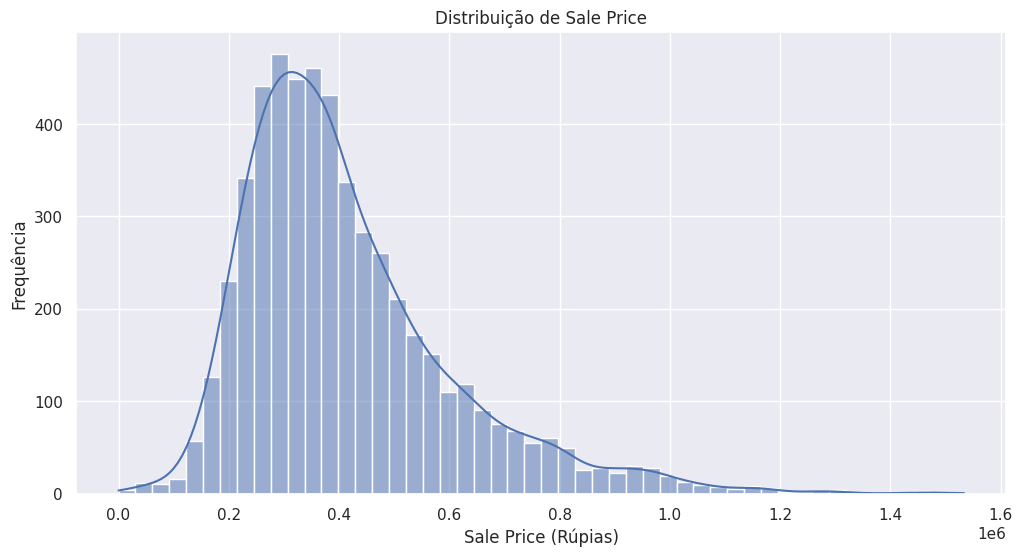

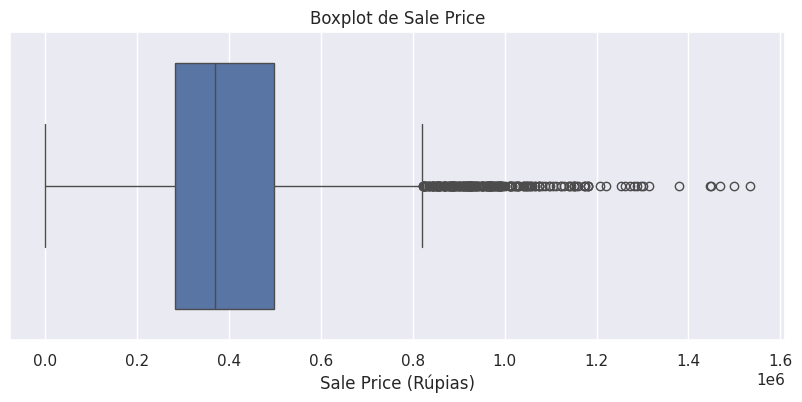

In [91]:
print("Descrição descritiva da coluna 'sale_price':")
display(df["sale_price"].describe())

# Histograma com KDE
plt.figure(figsize=(12, 6))
sns.histplot(df["sale_price"], bins=50, kde=True)
plt.title("Distribuição de Sale Price")
plt.xlabel("Sale Price (Rúpias)")
plt.ylabel("Frequência")
plt.show()

# Boxplot para ver outliers
plt.figure(figsize=(10, 4))
sns.boxplot(x=df["sale_price"])
plt.title("Boxplot de Sale Price")
plt.xlabel("Sale Price (Rúpias)")
plt.show()


## 3. Análise de valores ausentes

Agora vamos verificar:
- Quantos valores ausentes existem em cada coluna
- Qual o percentual de ausência
- Quais colunas exigem uma estratégia de tratamento mais cuidadosa


In [92]:
# Quantidade e percentual de valores ausentes por coluna
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    "Total Ausentes": missing_values,
    "Percentual (%)": missing_percent
})

print("Resumo de valores ausentes por coluna (apenas colunas com NaN):")
display(
    missing_df[missing_df["Total Ausentes"] > 0]
    .sort_values("Percentual (%)", ascending=False)
)


Resumo de valores ausentes por coluna (apenas colunas com NaN):


,Total Ausentes,Percentual (%)
original_price,2270,42.701279
car_availability,372,6.997743
transmission,274,5.154251
source,73,1.373213
body_type,10,0.188111
fitness_certificate,5,0.094056
registered_city,2,0.037622
registered_state,2,0.037622
car_rating,2,0.037622


<Figure size 1000x800 with 0 Axes>

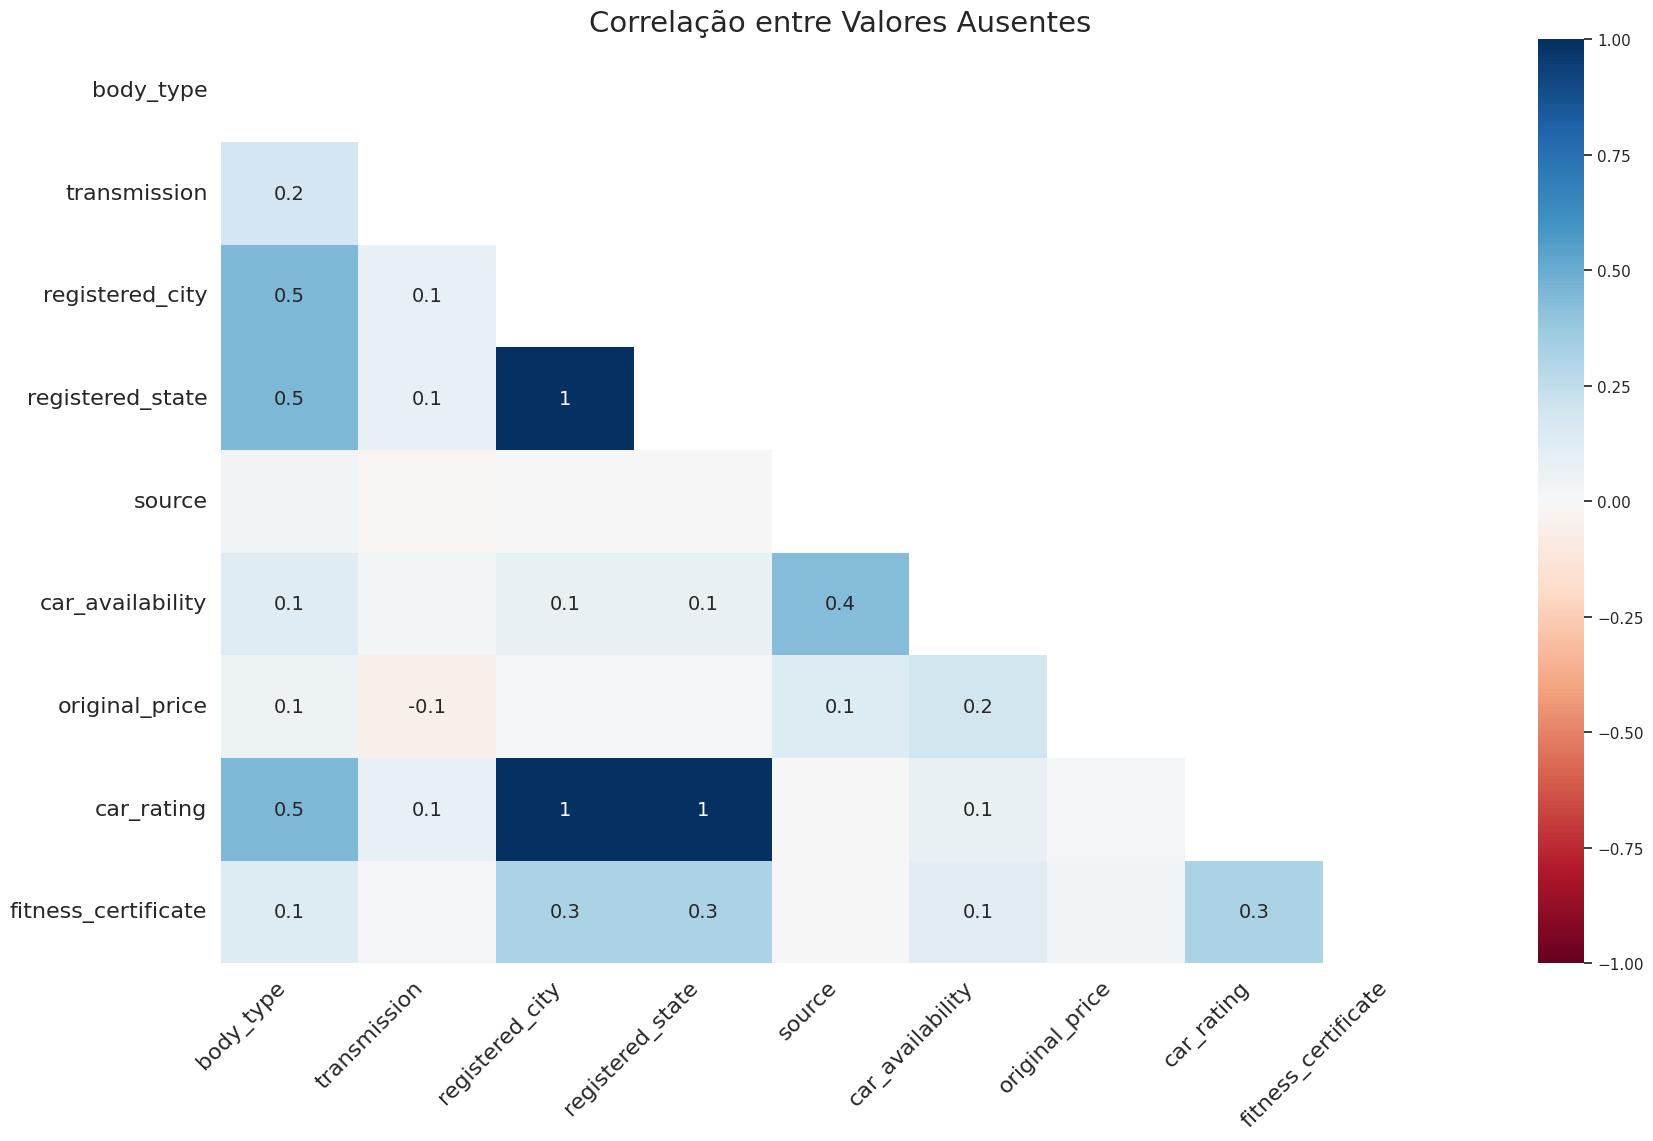

In [93]:
# Visualizando a correlação entre valores ausentes
plt.figure(figsize=(10, 8))
msno.heatmap(df)
plt.title('Correlação entre Valores Ausentes',fontsize=21)
plt.show()

### Diagnóstico dos valores ausentes

A partir da tabela de ausências e do mapa de correlação, observamos que:

- `original_price` tem cerca de **43% de valores ausentes**, sem uma correlação forte de ausência com outras colunas visíveis no dataset.
  - Isso indica que a ausência não parece totalmente aleatória, mas também não está concentrada em um único grupo simples.
  - Como essa variável é importante para entender o valor inicial do carro, precisaremos decidir se vamos **tratá-la com imputação específica** ou se vamos **excluí-la do modelo preditivo**.

- `car_availability` (\~7%), `transmission` (\~5%), `source` (\~1%) e `body_type` (\~0,2%) têm **ausência moderada/baixa** e aparecem com alguma correlação entre si e com a coluna `source`.
  - Vamos tratar cada uma delas separadamente com estratégias simples (por exemplo, imputação por categoria mais frequente ou criação de uma categoria "desconhecido(a)").

- As demais colunas (`registered_city`, `registered_state`, `car_rating`, `fitness_certificate` etc.) têm **menos de 0,1% de valores ausentes**.
  - Nessas colunas, o impacto é mínimo e podemos simplesmente **remover as poucas linhas com NaN** nessas variáveis.

Em resumo, a principal coluna que exige uma decisão cuidadosa é `original_price`, seguida por `car_availability`, `transmission`, `source` e `body_type`.


### Verificando se a ausência de `original_price` está associada ao preço de venda

Como `original_price` possui muitos valores ausentes, precisamos entender se essa ausência
é realmente aleatória ou se está relacionada ao próprio `sale_price`.

Nesta etapa vamos:

1. Dividir o dataset em dois grupos:
   - carros **com** `original_price`;
   - carros **sem** `original_price`.

2. Comparar as médias de `sale_price` entre os grupos.

3. Aplicar um **teste t** para verificar se a diferença é estatisticamente significativa.

4. Visualizar as distribuições com um boxplot.

Se existir diferença clara entre os grupos, isso indica que a ausência de `original_price`
não deve ser tratada como totalmente aleatória, exigindo mais cuidado no tratamento dessa coluna.


Tamanhos dos grupos:
Com original_price: 3046
Sem original_price: 2270

Médias de sale_price:
Com original_price: 446650.92317793827
Sem original_price: 370870.79691629956

Teste t para 'sale_price' entre grupos:
Estatística t: 14.9333
Valor p: 2.0257e-49


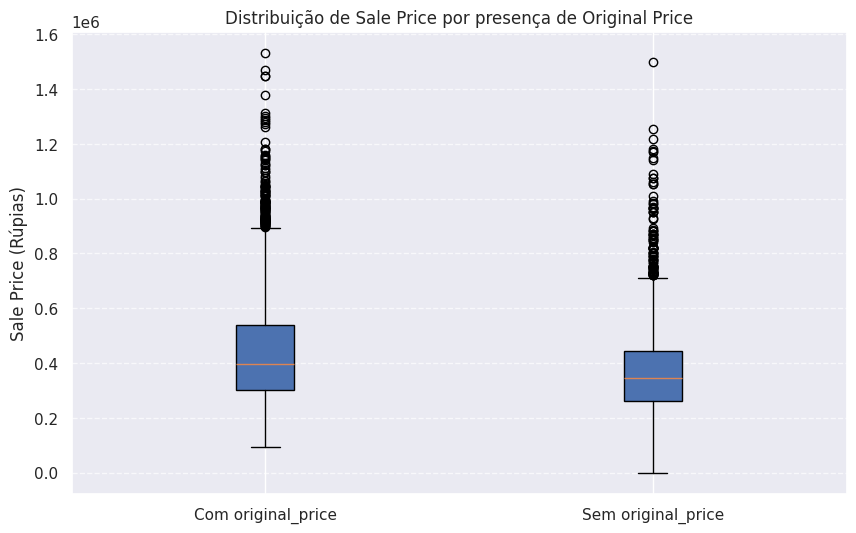

In [94]:
from scipy import stats

# Separar grupos
df_with_original = df.dropna(subset=["original_price"])
df_without_original = df[df["original_price"].isna()]

print("Tamanhos dos grupos:")
print("Com original_price:", len(df_with_original))
print("Sem original_price:", len(df_without_original))

print("\nMédias de sale_price:")
print("Com original_price:", df_with_original["sale_price"].mean())
print("Sem original_price:", df_without_original["sale_price"].mean())

# Teste t (assumindo variâncias diferentes)
t_stat, p_value = stats.ttest_ind(
    df_with_original["sale_price"],
    df_without_original["sale_price"],
    equal_var=False
)

print(f"\nTeste t para 'sale_price' entre grupos:")
print(f"Estatística t: {t_stat:.4f}")
print(f"Valor p: {p_value:.4e}")

# Boxplot
plt.figure(figsize=(10, 6))
data_to_plot = [
    df_with_original["sale_price"].dropna(),
    df_without_original["sale_price"].dropna()
]
plt.boxplot(data_to_plot, patch_artist=True,
            tick_labels=["Com original_price", "Sem original_price"])
plt.title("Distribuição de Sale Price por presença de Original Price")
plt.ylabel("Sale Price (Rúpias)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


O teste t mostrou uma diferença estatisticamente significativa nas médias de `sale_price`
entre carros com e sem `original_price` registrado. Isso indica que a ausência de
`original_price` não é completamente aleatória em relação ao preço de venda.

Na prática, não podemos assumir que `original_price` é MCAR; portanto, vamos tratar
essa coluna com cuidado (em vez de aplicar uma imputação simples) e considerar se
ela deve ou não ser usada no modelo final.


In [95]:
# Analisar a distribuição de 'make' para ambos os grupos
make_counts_with = df_with_original['make'].value_counts(normalize=True)
make_counts_without = df_without_original['make'].value_counts(normalize=True)

print("\nDistribuição da variável 'make' (Percentual):")
print("\nGrupo com 'original_price':")
print(make_counts_with.head()) # Exibir as principais marcas

print("\nGrupo sem 'original_price':")
print(make_counts_without.head()) # Exibir as principais marcas


Distribuição da variável 'make' (Percentual):

Grupo com 'original_price':
make
maruti        0.545634
hyundai       0.291530
honda         0.063362
renault       0.031188
volkswagen    0.028562
Name: proportion, dtype: float64

Grupo sem 'original_price':
make
maruti        0.472687
hyundai       0.341850
honda         0.080617
renault       0.033040
volkswagen    0.029075
Name: proportion, dtype: float64


A distribuição de `make` é bastante semelhante entre os grupos com e sem `original_price`.
Isso indica que a ausência dessa coluna **não está concentrada em marcas específicas**,
sendo mais provavelmente relacionada a outros fatores do anúncio.


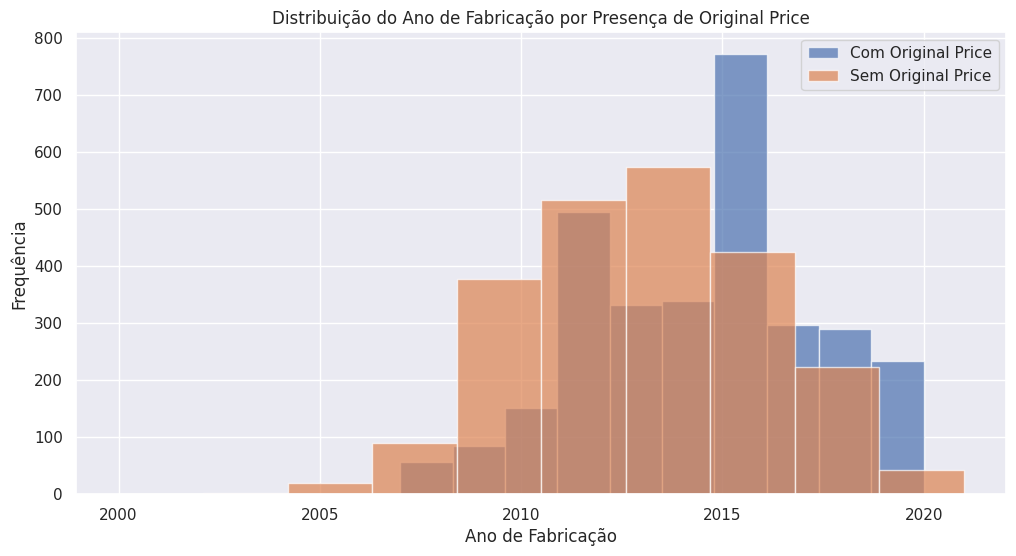


Teste Mann-Whitney U para 'yr_mfr' entre grupos com e sem 'original_price' ausente:
Estatística: 4468321.0000
Valor p: 0.0000
Há uma diferença estatisticamente significativa na distribuição de 'yr_mfr' entre os grupos.
Isso sugere que a ausência em 'original_price' pode estar relacionada ao ano de fabricação (indício de MAR).


In [96]:
# Analisar a distribuição de 'yr_mfr' para ambos os grupos (com e sem original_price)
plt.figure(figsize=(12, 6))
df_with_original['yr_mfr'].hist(alpha=0.7, label='Com Original Price')
df_without_original['yr_mfr'].hist(alpha=0.7, label='Sem Original Price')
plt.xlabel('Ano de Fabricação')
plt.ylabel('Frequência')
plt.title('Distribuição do Ano de Fabricação por Presença de Original Price')
plt.legend()
plt.show()

# Opcional: Teste estatístico para comparar as distribuições (por exemplo, teste Mann-Whitney U para dados não normais)
from scipy.stats import mannwhitneyu

stat, p = mannwhitneyu(df_with_original['yr_mfr'], df_without_original['yr_mfr'])

print(f"\nTeste Mann-Whitney U para 'yr_mfr' entre grupos com e sem 'original_price' ausente:")
print(f"Estatística: {stat:.4f}")
print(f"Valor p: {p:.4f}")

if p < 0.05:
    print("Há uma diferença estatisticamente significativa na distribuição de 'yr_mfr' entre os grupos.")
    print("Isso sugere que a ausência em 'original_price' pode estar relacionada ao ano de fabricação (indício de MAR).")
else:
    print("Não há uma diferença estatisticamente significativa na distribuição de 'yr_mfr' entre os grupos.")
    print("Isso sugere que a ausência em 'original_price' pode não estar fortemente relacionada ao ano de fabricação.")

### Resumo sobre `original_price` e tipo de ausência

- Carros com `original_price` registrado têm, em média, `sale_price` mais alto do que carros
  sem esse valor, e o teste t mostrou que essa diferença é estatisticamente significativa.
- As distribuições de `make` e `yr_mfr` são parecidas entre os grupos (apenas pequenas
  variações), então a ausência de `original_price` não parece concentrada em uma marca ou
  ano específicos.
- Ao mesmo tempo, a ausência de `original_price` está relacionada a variáveis observadas
  do dataset (especialmente `sale_price`), o que indica que essa ausência **não é MCAR**
  e é mais compatível com um comportamento do tipo **MAR**.

Por isso, `original_price` deve ser tratada com cuidado: uma imputação simples pode
introduzir viés. Nos próximos passos, podemos testar formas de imputar ou, dependendo dos
resultados, considerar não usar essa coluna no modelo preditivo final.


### Teste de diferentes métodos de imputação para `original_price`

Como `original_price` é uma variável importante e possui muitos valores ausentes,
vamos **experimentar diferentes formas de imputação** antes de decidir o que usar
no modelo final.

Nesta etapa vamos:

1. Criar cópias do dataset para cada método de imputação.
2. Usar um conjunto de variáveis numéricas relacionadas ao preço do carro  
   (`yr_mfr`, `kms_run`, `times_viewed`, `total_owners`,
   `broker_quote`, `emi_starts_from`, `booking_down_pymnt`) como preditoras.
3. Imputar `original_price` com três abordagens:
   - Regressão Linear;
   - KNN Imputer;
   - Random Forest Regressor.
4. Garantir que os valores imputados não sejam negativos.
5. Comparar as distribuições de `original_price` original (não ausente) com as
   distribuições geradas por cada método, usando histogramas e curvas de densidade (KDE).

O objetivo aqui é **ver qual método gera uma distribuição mais parecida com a dos
valores reais**, para então decidir qual imputação faz mais sentido utilizar.


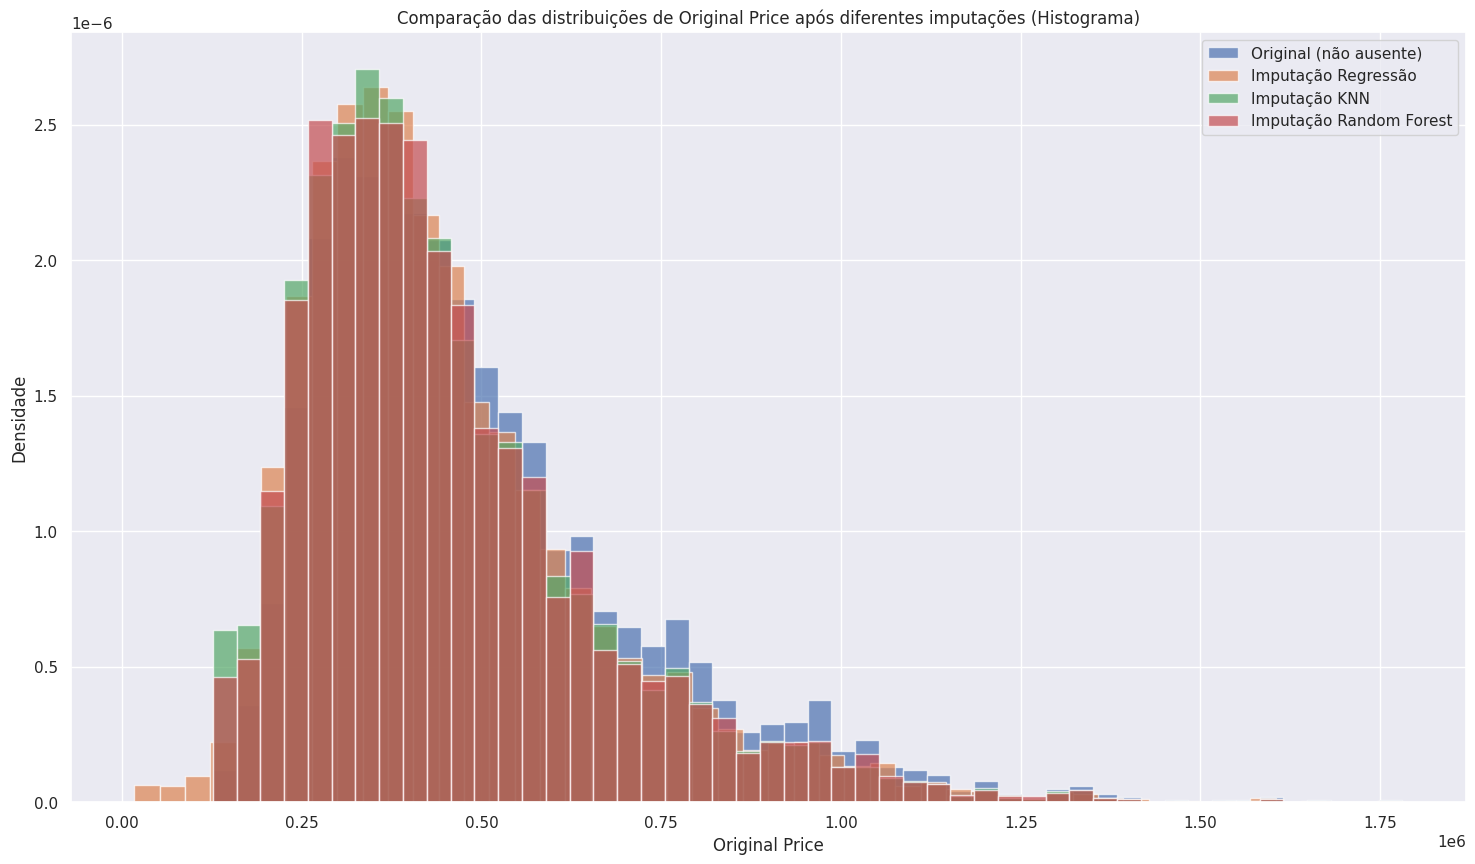

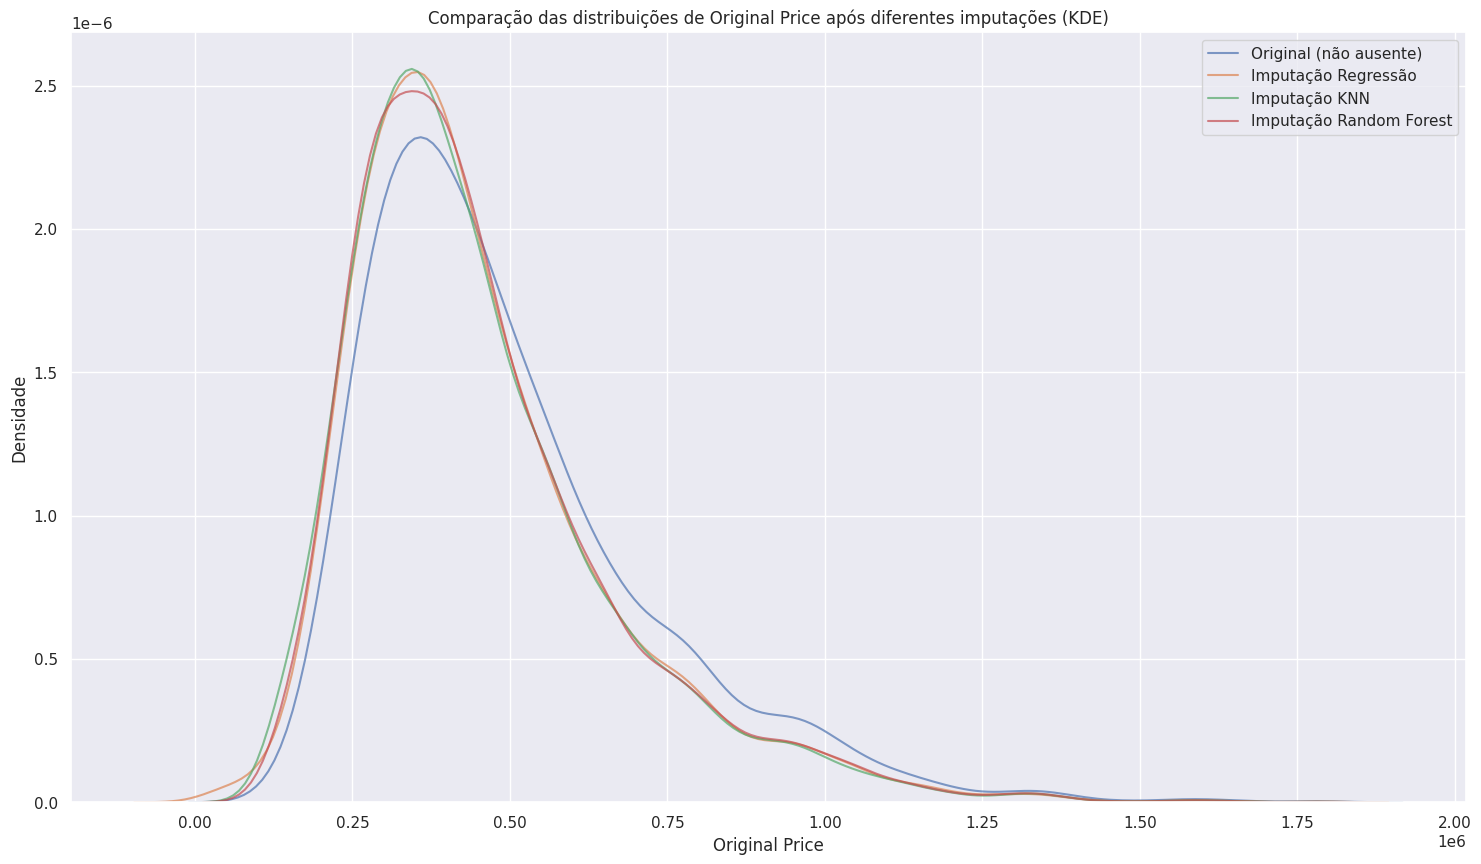

In [97]:
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Copiar o DataFrame para cada método de imputação
df_regression_imputed = df.copy()
df_knn_imputed = df.copy()
df_rf_imputed = df.copy()

# 2) Variáveis numéricas usadas como preditoras para original_price
imputation_features = [
    "yr_mfr",
    "kms_run",
    "times_viewed",
    "total_owners",
    "broker_quote",
    "emi_starts_from",
    "booking_down_pymnt",
]

# ========= Imputação por Regressão Linear =========
reg_cols = imputation_features

df_train_reg = df_regression_imputed.dropna(subset=["original_price"] + reg_cols)
df_pred_reg = df_regression_imputed[df_regression_imputed["original_price"].isna()]

if not df_train_reg.empty and not df_pred_reg.empty:
    reg_model = LinearRegression()
    reg_model.fit(df_train_reg[reg_cols], df_train_reg["original_price"])

    pred_original_reg = reg_model.predict(df_pred_reg[reg_cols])
    df_regression_imputed.loc[df_regression_imputed["original_price"].isna(), "original_price"] = pred_original_reg

# garantir não-negativo
df_regression_imputed["original_price"] = df_regression_imputed["original_price"].clip(lower=0)


# ========= Imputação por KNN =========
knn_cols = imputation_features + ["original_price"]

df_knn_temp = df_knn_imputed[knn_cols].copy()
knn_imputer = KNNImputer(n_neighbors=5)
df_knn_imputed[knn_cols] = knn_imputer.fit_transform(df_knn_temp)

df_knn_imputed["original_price"] = df_knn_imputed["original_price"].clip(lower=0)


# ========= Imputação por Random Forest =========
rf_cols = imputation_features

df_train_rf = df_rf_imputed.dropna(subset=["original_price"] + rf_cols)
df_pred_rf = df_rf_imputed[df_rf_imputed["original_price"].isna()]

if not df_train_rf.empty and not df_pred_rf.empty:
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(df_train_rf[rf_cols], df_train_rf["original_price"])

    pred_original_rf = rf_model.predict(df_pred_rf[rf_cols])
    df_rf_imputed.loc[df_rf_imputed["original_price"].isna(), "original_price"] = pred_original_rf

df_rf_imputed["original_price"] = df_rf_imputed["original_price"].clip(lower=0)


# ========= Comparação das distribuições =========

# Histograma
plt.figure(figsize=(18, 10))
plt.hist(df["original_price"].dropna(), bins=50, alpha=0.7, label="Original (não ausente)", density=True)
plt.hist(df_regression_imputed["original_price"], bins=50, alpha=0.7, label="Imputação Regressão", density=True)
plt.hist(df_knn_imputed["original_price"], bins=50, alpha=0.7, label="Imputação KNN", density=True)
plt.hist(df_rf_imputed["original_price"], bins=50, alpha=0.7, label="Imputação Random Forest", density=True)
plt.xlabel("Original Price")
plt.ylabel("Densidade")
plt.title("Comparação das distribuições de Original Price após diferentes imputações (Histograma)")
plt.legend()
plt.show()

# KDE
plt.figure(figsize=(18, 10))
sns.kdeplot(df["original_price"].dropna(), fill=False, alpha=0.7, label="Original (não ausente)")
sns.kdeplot(df_regression_imputed["original_price"], fill=False, alpha=0.7, label="Imputação Regressão")
sns.kdeplot(df_knn_imputed["original_price"], fill=False, alpha=0.7, label="Imputação KNN")
sns.kdeplot(df_rf_imputed["original_price"], fill=False, alpha=0.7, label="Imputação Random Forest")
plt.xlabel("Original Price")
plt.ylabel("Densidade")
plt.title("Comparação das distribuições de Original Price após diferentes imputações (KDE)")
plt.legend()
plt.show()

In [98]:
print("\n--- Comparação de Estatísticas Descritivas para 'original_price' ---")

# Original (non-missing) values
original_stats = df["original_price"].dropna().agg(['mean', 'median', 'std', 'skew', 'kurtosis'])
print("\nOriginal (Não Ausente):")
display(original_stats)

# Imputação por Regressão Linear
regression_stats = df_regression_imputed["original_price"].agg(['mean', 'median', 'std', 'skew', 'kurtosis'])
print("\nImputação Regressão Linear:")
display(regression_stats)

# Imputação por KNN
knn_stats = df_knn_imputed["original_price"].agg(['mean', 'median', 'std', 'skew', 'kurtosis'])
print("\nImputação KNN:")
display(knn_stats)

# Imputação por Random Forest
rf_stats = df_rf_imputed["original_price"].agg(['mean', 'median', 'std', 'skew', 'kurtosis'])
print("\nImputação Random Forest:")
display(rf_stats)

print("\n--- Análise Qualitativa (Baseada nas Observações Anteriores) ---")
print("Com base nos histogramas e KDEs gerados anteriormente (que mostram a forma da distribuição):\n")
print("O Random Forest Regressor pareceu replicar melhor a forma geral da distribuição dos valores originais, especialmente a cauda direita (valores mais altos), comparado aos outros métodos. Regressão Linear tende a 'suavizar' a distribuição demais e KNN pode introduzir ruído ou não capturar bem a forma complexa da distribuição.\n")
print("Considerando a análise visual das distribuições e a comparação das estatísticas descritivas acima, o Random Forest Imputer geralmente oferece um equilíbrio melhor entre a preservação da forma da distribuição e a introdução de menos viés.")



--- Comparação de Estatísticas Descritivas para 'original_price' ---

Original (Não Ausente):


mean        493390.918582
median      440546.000000
std         224965.820967
skew             1.322216
kurtosis         2.212924
Name: original_price, dtype: float64


Imputação Regressão Linear:


mean        452841.159134
median      403508.635304
std         210352.156195
skew             1.391136
kurtosis         2.756860
Name: original_price, dtype: float64


Imputação KNN:


mean        448999.393115
median      401451.500000
std         209087.632638
skew             1.410886
kurtosis         2.834196
Name: original_price, dtype: float64


Imputação Random Forest:


mean        453559.843328
median      404760.540000
std         209562.145952
skew             1.429640
kurtosis         2.819803
Name: original_price, dtype: float64


--- Análise Qualitativa (Baseada nas Observações Anteriores) ---
Com base nos histogramas e KDEs gerados anteriormente (que mostram a forma da distribuição):

O Random Forest Regressor pareceu replicar melhor a forma geral da distribuição dos valores originais, especialmente a cauda direita (valores mais altos), comparado aos outros métodos. Regressão Linear tende a 'suavizar' a distribuição demais e KNN pode introduzir ruído ou não capturar bem a forma complexa da distribuição.

Considerando a análise visual das distribuições e a comparação das estatísticas descritivas acima, o Random Forest Imputer geralmente oferece um equilíbrio melhor entre a preservação da forma da distribuição e a introdução de menos viés.


### Comparação dos métodos de imputação para `original_price`

Após testar três métodos de imputação (`Regressão Linear`, `KNN` e `Random Forest`),
observamos que todos eles alteram a distribuição original de `original_price` em
algum grau — o que é esperado, já que os valores ausentes não são MCAR.

Os três métodos aproximam a distribuição original, mas todos tendem a concentrar
mais valores na faixa média e a reduzir a variabilidade, especialmente na cauda
direita (carros mais caros). A comparação quantitativa (média, mediana, desvio
padrão, skewness e kurtosis) mostra que nenhum método preserva perfeitamente a
distribuição original.

Visualmente, as distribuições geradas por Regressão Linear, KNN e Random Forest
são bastante parecidas. Entre elas, o Random Forest parece capturar ligeiramente
melhor a cauda direita, mas a diferença é pequena. Por isso, adotamos o Random
Forest como o melhor dos métodos testados **apenas para fins exploratórios**, e
mantemos a ressalva de que a imputação de `original_price` deve ser interpretada
com cautela, já que a ausência nessa coluna não é completamente aleatória.

### Imputação final de `original_price` via tabela de preços

Aplicamos a `tabela_precos` (modelo/geração/transmissão + proximidade de ano) para preencher `original_price`. Se ainda restarem `NaN`, usamos a média como fallback. Os métodos testados anteriormente ficam como comparação, não alteram o `df` final.

In [99]:
import numpy as np
import pandas as pd

# Tabela de preços de lançamento (do notebook original)
tabela_precos = {
    'Hyundai Grand i10': [
        {'geracao_ano_inicio': 2013, 'geracao_ano_fim': 2019, 'transmissao': 'MT', 'preco_base': 458000, 'fonte': 'https://www.autocarindia.com/car-news/2017-hyundai-grand-i10-facelift-launched-at-rs-458-lakh-404065'},
        {'geracao_ano_inicio': 2013, 'geracao_ano_fim': 2019, 'transmissao': 'AT', 'preco_base': 458000 + 68000, 'fonte': 'https://www.autocarindia.com/car-news/2017-hyundai-grand-i10-facelift-launched-at-rs-458-lakh-404065'}
    ],
    'Hyundai Grand i10 Nios': [
        {'geracao_ano_inicio': 2019, 'geracao_ano_fim': 2024, 'transmissao': 'MT', 'preco_base': 499000, 'fonte': 'https://www.cardekho.com/india-car-news/hyundai-verna-2023-launched-at-rs-1090-lakh-undercuts-its-rivals-by-over-rs-40000-30574.htm'},
        {'geracao_ano_inicio': 2019, 'geracao_ano_fim': 2024, 'transmissao': 'AT', 'preco_base': 499000 + 180000, 'fonte': 'https://www.cardekho.com/india-car-news/hyundai-verna-2023-launched-at-rs-1090-lakh-undercuts-its-rivals-by-over-rs-40000-30574.htm'}
    ],
    'Maruti Alto K10': [
        {'geracao_ano_inicio': 2014, 'geracao_ano_fim': 2020, 'transmissao': 'MT', 'preco_base': 306000, 'fonte': 'https://www.carwale.com/news/maruti-suzuki-celerio-zxi-amt-launched-at-rs-499-lakh/?utm_source=chatgpt.com'},
        {'geracao_ano_inicio': 2014, 'geracao_ano_fim': 2020, 'transmissao': 'AT', 'preco_base': 306000 + 45000, 'fonte': 'https://www.carwale.com/maruti-suzuki-cars/alto-k10-2014-2020/vxi-amt-2014-2018/'}
    ],
    'Maruti Ritz': [
        {'geracao_ano_inicio': 2009, 'geracao_ano_fim': 2017, 'transmissao': 'MT', 'preco_base': 459000, 'fonte': 'https://www.cardekho.com/maruti/ritz/maruti-ritz-lxi.html?utm_source=chatgpt.com'}
    ],
    'Hyundai i10': [
        {'geracao_ano_inicio': 2007, 'geracao_ano_fim': 2013, 'transmissao': 'MT', 'preco_base': 358000, 'fonte': 'https://www.cardekho.com/carmodels/Hyundai/Hyundai_i10_2007-2010/'},
        {'geracao_ano_inicio': 2007, 'geracao_ano_fim': 2013, 'transmissao': 'AT', 'preco_base': 358000 + 60000, 'fonte': 'https://www.cardekho.com/carmodels/Hyundai/Hyundai_i10_2007-2010/'},
        {'geracao_ano_inicio': 2010, 'geracao_ano_fim': 2017, 'transmissao': 'MT', 'preco_base': 462000, 'fonte': 'https://www.carwale.com/hyundai-cars/i10-2007-2010/'},
        {'geracao_ano_inicio': 2010, 'geracao_ano_fim': 2017, 'transmissao': 'AT', 'preco_base': 462000 + 60000, 'fonte': 'https://www.carwale.com/hyundai-cars/i10-2007-2010/'}
    ],
    'Hyundai Eon': [
        {'geracao_ano_inicio': 2011, 'geracao_ano_fim': 2019, 'transmissao': 'MT', 'preco_base': 269000, 'fonte': 'https://www.autocarindia.com/car-news/hyundai-eon-launched-at-rs-269-lakh-270201?utm_source=chatgpt.com'}
    ],
    'Maruti Swift': [
        {'geracao_ano_inicio': 2005, 'geracao_ano_fim': 2010, 'transmissao': 'MT', 'preco_base': 387000, 'fonte': 'https://www.cardekho.com/india-car-news/watch-heres-how-the-prices-of-the-maruti-swift-have-gone-up-over-the-years-since-2005-32585.htm?utm_source=chatgpt.com'},
        {'geracao_ano_inicio': 2011, 'geracao_ano_fim': 2017, 'transmissao': 'MT', 'preco_base': 422000, 'fonte': 'https://www.cardekho.com/india-car-news/watch-heres-how-the-prices-of-the-maruti-swift-have-gone-up-over-the-years-since-2005-32585.htm?utm_source=chatgpt.com'},
        {'geracao_ano_inicio': 2011, 'geracao_ano_fim': 2017, 'transmissao': 'AT', 'preco_base': 422000 + 60000, 'fonte': 'https://www.cardekho.com/india-car-news/watch-heres-how-the-prices-of-the-maruti-swift-have-gone-up-over-the-years-since-2005-32585.htm?utm_source=chatgpt.com'},
        {'geracao_ano_inicio': 2018, 'geracao_ano_fim': 2024, 'transmissao': 'MT', 'preco_base': 499000, 'fonte': 'https://auto.ndtv.com/news/2018-maruti-suzuki-swift-launched-in-india-prices-start-at-rs-499-lakh-1806437?utm_source=chatgpt.com'},
        {'geracao_ano_inicio': 2018, 'geracao_ano_fim': 2024, 'transmissao': 'AT', 'preco_base': 499000 + 45000, 'fonte': 'https://auto.ndtv.com/news/2018-maruti-suzuki-swift-launched-in-india-prices-start-at-rs-499-lakh-1806437?utm_source=chatgpt.com'}
    ],
    'Maruti Alto 800': [
        {'geracao_ano_inicio': 2012, 'geracao_ano_fim': 2022, 'transmissao': 'MT', 'preco_base': 225000, 'fonte': 'https://www.cardekho.com/india-car-news/maruti-alto-800-launched-at-rs-244-lakh-9488.htm?utm_source=chatgpt.com'}
    ],
    'Hyundai Creta': [
        {'geracao_ano_inicio': 2015, 'geracao_ano_fim': 2020, 'transmissao': 'MT', 'preco_base': 859000, 'fonte': 'https://www.cardekho.com/hyundai/creta-2015-2020'},
        {'geracao_ano_inicio': 2015, 'geracao_ano_fim': 2020, 'transmissao': 'AT', 'preco_base': 859000 + 120000, 'fonte': 'https://www.cardekho.com/hyundai/creta-2015-2020'},
        {'geracao_ano_inicio': 2020, 'geracao_ano_fim': 2024, 'transmissao': 'MT', 'preco_base': 999000, 'fonte': 'https://www.cardekho.com/hyundai/creta-2015-2020'},
        {'geracao_ano_inicio': 2020, 'geracao_ano_fim': 2024, 'transmissao': 'AT', 'preco_base': 999000 + 180000, 'fonte': 'https://www.cardekho.com/hyundai/creta-2015-2020'},
        {'geracao_ano_inicio': 2024, 'geracao_ano_fim': 2024, 'transmissao': 'MT', 'preco_base': 1099000, 'fonte': 'https://www.hyundai.com/in/en/find-a-car/creta/highlights'},
        {'geracao_ano_inicio': 2024, 'geracao_ano_fim': 2024, 'transmissao': 'AT', 'preco_base': 1099000 + 130000, 'fonte': 'https://www.hyundai.com/in/en/find-a-car/creta/highlights'}
    ],
    'Hyundai i20': [
        {'geracao_ano_inicio': 2008, 'geracao_ano_fim': 2014, 'transmissao': 'MT', 'preco_base': 479000, 'fonte': 'https://www.carwale.com/hyundai-cars/i20-2008-2014/'},
        {'geracao_ano_inicio': 2008, 'geracao_ano_fim': 2014, 'transmissao': 'AT', 'preco_base': 479000 + 60000, 'fonte': 'https://www.carwale.com/hyundai-cars/i20-2008-2014/'},
        {'geracao_ano_inicio': 2014, 'geracao_ano_fim': 2020, 'transmissao': 'MT', 'preco_base': 489000, 'fonte': 'https://timesofindia.indiatimes.com/auto/cars/elite-i20-launch-details'},
        {'geracao_ano_inicio': 2014, 'geracao_ano_fim': 2020, 'transmissao': 'AT', 'preco_base': 489000 + 100000, 'fonte': 'https://timesofindia.indiatimes.com/auto/cars/elite-i20-launch-details'},
        {'geracao_ano_inicio': 2020, 'geracao_ano_fim': 2024, 'transmissao': 'MT', 'preco_base': 679000, 'fonte': 'https://www.carwale.com/compare-cars/hyundai-i20-2020-vs-elite-i20-2014-2015/'},
        {'geracao_ano_inicio': 2020, 'geracao_ano_fim': 2024, 'transmissao': 'AT', 'preco_base': 679000 + 150000, 'fonte': 'https://www.carwale.com/compare-cars/hyundai-i20-2020-vs-elite-i20-2014-2015/'}
    ],
    'Hyundai Santro Xing': [
        {'geracao_ano_inicio': 2003, 'geracao_ano_fim': 2014, 'transmissao': 'MT', 'preco_base': 299000, 'fonte': 'https://www.carwale.com/hyundai-cars/santro-2008-2014/'},
        {'geracao_ano_inicio': 2003, 'geracao_ano_fim': 2014, 'transmissao': 'AT', 'preco_base': 299000, 'fonte': 'https://www.carwale.com/hyundai-cars/santro-2008-2014/'}
    ],
    'Hyundai Santro': [
        {'geracao_ano_inicio': 2018, 'geracao_ano_fim': 2022, 'transmissao': 'MT', 'preco_base': 389000, 'fonte': 'https://www.carwale.com/hyundai-cars/santro-2018-2022/'},
        {'geracao_ano_inicio': 2018, 'geracao_ano_fim': 2022, 'transmissao': 'AT', 'preco_base': 389000 + 40000, 'fonte': 'https://www.carwale.com/hyundai-cars/santro-2018-2022/'}
    ],
    'Maruti Swift Dzire': [
        {'geracao_ano_inicio': 2008, 'geracao_ano_fim': 2012, 'transmissao': 'MT', 'preco_base': 449000, 'fonte': 'https://www.cardekho.com/maruti/dzire-2008-2012'},
        {'geracao_ano_inicio': 2008, 'geracao_ano_fim': 2012, 'transmissao': 'AT', 'preco_base': 449000 + 80000, 'fonte': 'https://www.cardekho.com/maruti/dzire-2008-2012'},
        {'geracao_ano_inicio': 2012, 'geracao_ano_fim': 2017, 'transmissao': 'MT', 'preco_base': 479000, 'fonte': 'https://www.carwale.com/maruti-cars/dzire-2012-2017/'},
        {'geracao_ano_inicio': 2012, 'geracao_ano_fim': 2017, 'transmissao': 'AT', 'preco_base': 479000 + 60000, 'fonte': 'https://www.carwale.com/maruti-cars/dzire-2012-2017/'},
        {'geracao_ano_inicio': 2017, 'geracao_ano_fim': 2024, 'transmissao': 'MT', 'preco_base': 545000, 'fonte': 'https://www.carwale.com/maruti-cars/dzire-2017-2024/'},
        {'geracao_ano_inicio': 2017, 'geracao_ano_fim': 2024, 'transmissao': 'AT', 'preco_base': 545000 + 60000, 'fonte': 'https://www.carwale.com/maruti-cars/dzire-2017-2024/'}
    ],
    'Maruti Wagon R 1.0': [
        {'geracao_ano_inicio': 2010, 'geracao_ano_fim': 2019, 'transmissao': 'MT', 'preco_base': 328000, 'fonte': 'https://www.carwale.com/maruti-suzuki-cars/wagon-r-2010-2019/'},
        {'geracao_ano_inicio': 2010, 'geracao_ano_fim': 2019, 'transmissao': 'AT', 'preco_base': 328000, 'fonte': 'https://www.carwale.com/maruti-suzuki-cars/wagon-r-2010-2019/'},
        {'geracao_ano_inicio': 2019, 'geracao_ano_fim': 2024, 'transmissao': 'MT', 'preco_base': 419000, 'fonte': 'https://www.carwale.com/maruti-suzuki-cars/wagon-r-2019/'},
        {'geracao_ano_inicio': 2019, 'geracao_ano_fim': 2024, 'transmissao': 'AT', 'preco_base': 419000 + 55000, 'fonte': 'https://www.carwale.com/maruti-suzuki-cars/wagon-r-2019/'}
    ],
    'Maruti Ertiga': [
        {'geracao_ano_inicio': 2012, 'geracao_ano_fim': 2018, 'transmissao': 'MT', 'preco_base': 589000, 'fonte': 'https://www.economictimes.indiatimes.com/maruti-suzuki-launched-ertiga-at-starting-price-of-rs-5-89-lakh/articleshow/12634917.cms?utm_source=chatgpt.com'},
        {'geracao_ano_inicio': 2012, 'geracao_ano_fim': 2018, 'transmissao': 'AT', 'preco_base': 589000 + 110000, 'fonte': 'https://www.economictimes.indiatimes.com/maruti-suzuki-launched-ertiga-at-starting-price-of-rs-5-89-lakh/articleshow/12634917.cms?utm_source=chatgpt.com'},
        {'geracao_ano_inicio': 2018, 'geracao_ano_fim': 2024, 'transmissao': 'MT', 'preco_base': 744000, 'fonte': 'https://www.autocarindia.com/car-news/2018-maruti-suzuki-ertiga-launched-at-rs-744-lakh-410524?utm_source=chatgpt.com'},
        {'geracao_ano_inicio': 2018, 'geracao_ano_fim': 2024, 'transmissao': 'AT', 'preco_base': 744000 + 120000, 'fonte': 'https://www.autocarindia.com/car-news/2018-maruti-suzuki-ertiga-launched-at-rs-744-lakh-410524?utm_source=chatgpt.com'}
    ],
    'Honda Amaze': [
        {'geracao_ano_inicio': 2013, 'geracao_ano_fim': 2018, 'transmissao': 'MT', 'preco_base': 499000, 'fonte': 'https://www.autocarindia.com/car-news/honda-amaze-launched-at-rs-499-lakh-42730?utm_source=chatgpt.com'},
        {'geracao_ano_inicio': 2013, 'geracao_ano_fim': 2018, 'transmissao': 'AT', 'preco_base': 499000 + 80000, 'fonte': 'https://www.autocarindia.com/car-news/honda-amaze-launched-at-rs-499-lakh-42730?utm_source=chatgpt.com'}
    ],
    'Honda City': [
        {'geracao_ano_inicio': 2022, 'geracao_ano_fim': 2024, 'transmissao': 'MT', 'preco_base': 1195000, 'fonte': 'https://timesofindia.indiatimes.com/auto/cars/2023-honda-city-facelift-launched-in-india-at-rs-11-49-lakh-price-variants-specs-features/articleshow/98359742.cms'},
        {'geracao_ano_inicio': 2022, 'geracao_ano_fim': 2024, 'transmissao': 'AT', 'preco_base': 1195000 + 100000, 'fonte': 'https://timesofindia.indiatimes.com/auto/cars/2023-honda-city-facelift-launched-in-india-at-rs-11-49-lakh-price-variants-specs-features/articleshow/98359742.cms'}
    ],
    'Volkswagen Polo': [
        {'geracao_ano_inicio': 2010, 'geracao_ano_fim': 2022, 'transmissao': 'MT', 'preco_base': 645000, 'fonte': 'https://www.carwale.com/volkswagen-cars/polo/?utm_source=chatgpt.com'},
        {'geracao_ano_inicio': 2010, 'geracao_ano_fim': 2022, 'transmissao': 'AT', 'preco_base': 645000 + 120000, 'fonte': 'https://www.carwale.com/volkswagen-cars/polo/?utm_source=chatgpt.com'}
    ],
    'Maruti Celerio': [
        {'geracao_ano_inicio': 2021, 'geracao_ano_fim': 2024, 'transmissao': 'MT', 'preco_base': 499000, 'fonte': 'https://www.businesstoday.in/auto/story/maruti-suzuki-celerio-launched-today-check-features-mileage-and-other-details-311784-2021-11-10?utm_source=chatgpt.com'},
        {'geracao_ano_inicio': 2021, 'geracao_ano_fim': 2024, 'transmissao': 'AT', 'preco_base': 499000 + 150000, 'fonte': 'https://www.businesstoday.in/auto/story/maruti-suzuki-celerio-launched-today-check-features-mileage-and-other-details-311784-2021-11-10?utm_source=chatgpt.com'}
    ],
    'Toyota Innova Crysta': [
        {'geracao_ano_inicio': 2016, 'geracao_ano_fim': 2024, 'transmissao': 'MT', 'preco_base': 1779000, 'fonte': 'https://www.indiatoday.in/auto/new-launches/story/toyota-innova-crysta-touringsport-launched-in-india-at-rs-17-79-lakh-975162-2017-05-04?utm_source=chatgpt.com'},
        {'geracao_ano_inicio': 2016, 'geracao_ano_fim': 2024, 'transmissao': 'AT', 'preco_base': 1779000 + 250000, 'fonte': 'https://www.indiatoday.in/auto/new-launches/story/toyota-innova-crysta-touringsport-launched-in-india-at-rs-17-79-lakh-975162-2017-05-04?utm_source=chatgpt.com'}
    ],
    'Hyundai Verna': [
        {'geracao_ano_inicio': 2023, 'geracao_ano_fim': 2024, 'transmissao': 'MT', 'preco_base': 1090000, 'fonte': 'https://www.indiatoday.in/auto/new-launches/story/hyundai-verna-2023-launched-in-india-at-rs-11-49-lakh-2489313-2024-01-16?utm_source=chatgpt.com'},
        {'geracao_ano_inicio': 2023, 'geracao_ano_fim': 2024, 'transmissao': 'AT', 'preco_base': 1090000 + 130000, 'fonte': 'https://www.indiatoday.in/auto/new-launches/story/hyundai-verna-2023-launched-in-india-at-rs-11-49-lakh-2489313-2024-01-16?utm_source=chatgpt.com'}
    ],
    'Renault Kwid': [
        {'geracao_ano_inicio': 2015, 'geracao_ano_fim': 2019, 'transmissao': 'MT', 'preco_base': 276000, 'fonte': 'https://www.wikipedia.org/wiki/Renault_Kwid'},
        {'geracao_ano_inicio': 2015, 'geracao_ano_fim': 2019, 'transmissao': 'AT', 'preco_base': 276000 + 30000, 'fonte': 'https://www.cardekho.com/carmodels/Renault/Renault_KWID_2015-2019'},
        {'geracao_ano_inicio': 2024, 'geracao_ano_fim': 2024, 'transmissao': 'MT', 'preco_base': 469000, 'fonte': 'https://www.carwale.com/news/2024-renault-kwid-launched-prices-in-india-start-from-rs-469-lakh/?utm_source=chatgpt.com'},
        {'geracao_ano_inicio': 2024, 'geracao_ano_fim': 2024, 'transmissao': 'AT', 'preco_base': 469000 + 45000, 'fonte': 'https://www.carwale.com/news/2024-renault-kwid-launched-prices-in-india-start-from-rs-469-lakh/?utm_source=chatgpt.com'}
    ],
    'Maruti Vitara Brezza': [
        {'geracao_ano_inicio': 2016, 'geracao_ano_fim': 2022, 'transmissao': 'MT', 'preco_base': 699000, 'fonte': 'https://www.carandbike.com/news/maruti-suzuki-vitara-brezza-launched-in-india-prices-start-from-rs-699-lakh-1284788?utm_source=chatgpt.com'},
        {'geracao_ano_inicio': 2016, 'geracao_ano_fim': 2022, 'transmissao': 'AT', 'preco_base': 699000 + 140000, 'fonte': 'https://www.carandbike.com/news/maruti-suzuki-vitara-brezza-launched-in-india-prices-start-from-rs-699-lakh-1284788?utm_source=chatgpt.com'}
    ],
    'Ford EcoSport': [
        {'geracao_ano_inicio': 2013, 'geracao_ano_fim': 2017, 'transmissao': 'MT', 'preco_base': 559000, 'fonte': 'https://timesofindia.indiatimes.com/auto/cars/ford-ecosport-launched-at-rs-559-lakh'},
        {'geracao_ano_inicio': 2013, 'geracao_ano_fim': 2017, 'transmissao': 'AT', 'preco_base': 559000 + 100000, 'fonte': 'https://timesofindia.indiatimes.com/auto/cars/ford-ecosport-launched-at-rs-559-lakh'},
        {'geracao_ano_inicio': 2017, 'geracao_ano_fim': 2021, 'transmissao': 'MT', 'preco_base': 731000, 'fonte': 'https://www.carwale.com/ford-cars/ecosport-2013-2015/'},
        {'geracao_ano_inicio': 2017, 'geracao_ano_fim': 2021, 'transmissao': 'AT', 'preco_base': 731000 + 100000, 'fonte': 'https://www.carwale.com/ford-cars/ecosport-2013-2015/'}
    ],
    'Maruti Eeco': [
        {'geracao_ano_inicio': 2009, 'geracao_ano_fim': 2024, 'transmissao': 'MT', 'preco_base': 570000, 'fonte': 'https://timesofindia.indiatimes.com/auto/cars/2025-maruti-suzuki-eeco-launched-rs-5-7-lakh-gets-6-airbags-caption-seats/articleshow/120475621.cms?utm_source=chatgpt.com'}
    ],
    'Hyundai Elite i20': [
        {'geracao_ano_inicio': 2014, 'geracao_ano_fim': 2020, 'transmissao': 'MT', 'preco_base': 489000, 'fonte': 'https://www.carwale.com/compare-cars/hyundai-i20-2020-vs-elite-i20-2014-2015/'},
        {'geracao_ano_inicio': 2014, 'geracao_ano_fim': 2020, 'transmissao': 'AT', 'preco_base': 489000 + 100000, 'fonte': 'https://www.carwale.com/compare-cars/hyundai-i20-2020-vs-elite-i20-2014-2015/'}
    ]
}

# Imputar original_price usando a tabela
missing_idx = df[df['original_price'].isna()].index
imputed_count = 0
for idx in missing_idx:
    model = str(df.loc[idx, 'car_name']).title()
    yr_mfr = df.loc[idx, 'yr_mfr']
    transmission = df.loc[idx, 'transmission']

    found_price = None
    best_match = None
    min_year_distance = float('inf')

    if model in tabela_precos:
        for info in tabela_precos[model]:
            trans_match = False
            if pd.notna(transmission):
                if str(transmission).lower() == 'automatic' and info['transmissao'].lower() == 'at':
                    trans_match = True
                elif str(transmission).lower() == 'manual' and info['transmissao'].lower() == 'mt':
                    trans_match = True

            if trans_match:
                if info['geracao_ano_inicio'] <= yr_mfr <= info['geracao_ano_fim']:
                    found_price = info['preco_base']
                    break
                year_dist = min(abs(yr_mfr - info['geracao_ano_inicio']), abs(yr_mfr - info['geracao_ano_fim']))
                if year_dist < min_year_distance:
                    min_year_distance = year_dist
                    best_match = info

    if found_price is None and best_match is not None:
        found_price = best_match['preco_base']

    if found_price is not None:
        df.loc[idx, 'original_price'] = found_price
        imputed_count += 1

print(f"Imputação via tabela_precos preenchida para {imputed_count} registros. Restantes: {df['original_price'].isna().sum()}")

# Fallback: média
if df['original_price'].isna().any():
    mean_price = df['original_price'].mean()
    df['original_price'] = df['original_price'].fillna(mean_price)
    print(f"Após fallback de média, NaNs restantes: {df['original_price'].isna().sum()}")

Imputação via tabela_precos preenchida para 1460 registros. Restantes: 810
Após fallback de média, NaNs restantes: 0


### Tratamento de valores ausentes em `transmission`

Investigamos associação de ausência com outras variáveis; como é categórica com poucos `NaN`, preenchemos com a categoria explícita `unknown`, preservando a informação de falta sem chutes complexos.

Valores ausentes em 'transmission': 274 (5.15%)

Qui-quadrado entre 'transmission_missing' e 'fuel_type':
  chi2 = 14.53, p = 0.0023

Qui-quadrado entre 'transmission_missing' e 'make':
  chi2 = 78.22, p = 0.0000


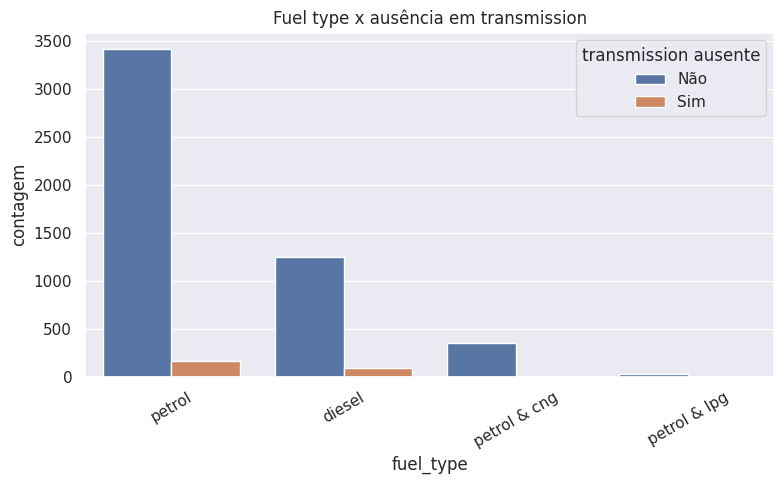


Teste t para 'sale_price' entre grupos com/sem transmission:
  t = -12.98, p = 0.0000

Teste t para 'kms_run' entre grupos com/sem transmission:
  t = 4.00, p = 0.0001


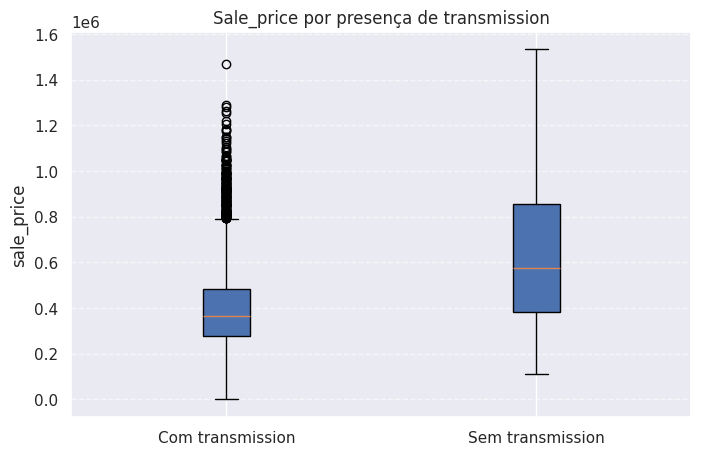

In [100]:
from scipy.stats import chi2_contingency, ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Quantidade de valores ausentes
n_missing = df["transmission"].isna().sum()
pct_missing = 100 * n_missing / len(df)
print(f"Valores ausentes em 'transmission': {n_missing} ({pct_missing:.2f}%)")

# 2) Flag de ausência
df["transmission_missing"] = df["transmission"].isna()

# ---- Testes com variáveis categóricas ----
for col in ["fuel_type", "make"]:
    ct = pd.crosstab(df[col], df["transmission_missing"])
    chi2, p, dof, _ = chi2_contingency(ct)
    print(f"\nQui-quadrado entre 'transmission_missing' e '{col}':")
    print(f"  chi2 = {chi2:.2f}, p = {p:.4f}")

# Gráfico de barras para fuel_type
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="fuel_type", hue="transmission_missing")
plt.title("Fuel type x ausência em transmission")
plt.xlabel("fuel_type")
plt.ylabel("contagem")
plt.legend(title="transmission ausente", labels=["Não", "Sim"])
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# ---- Testes com variáveis numéricas ----
present = df[~df["transmission_missing"]]
missing = df[df["transmission_missing"]]

for col in ["sale_price", "kms_run"]:
    t, p = ttest_ind(present[col], missing[col], equal_var=False, nan_policy="omit")
    print(f"\nTeste t para '{col}' entre grupos com/sem transmission:")
    print(f"  t = {t:.2f}, p = {p:.4f}")

# Boxplot de sale_price
plt.figure(figsize=(8, 5))
plt.boxplot(
    [present["sale_price"].dropna(), missing["sale_price"].dropna()],
    tick_labels=["Com transmission", "Sem transmission"],
    patch_artist=True,
)
plt.title("Sale_price por presença de transmission")
plt.ylabel("sale_price")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

# Remover flag temporária (apenas análise, sem imputar ainda)
df.drop(columns=["transmission_missing"], inplace=True)



Os gráficos confirmam os resultados dos testes estatísticos:

- A ausência em `transmission` aparece em todos os tipos de combustível, mas sempre
  como uma fração pequena de cada categoria. Ou seja, existe associação com
  `fuel_type`, mas não há concentração extrema em um único tipo.

- Já em relação a `sale_price`, os carros sem `transmission` preenchida tendem a
  ser mais caros e apresentam maior variabilidade, o que indica que a ausência
  não é completamente aleatória em relação ao preço (não é MCAR).

Como a proporção de valores ausentes em `transmission` é pequena (~5%) e a
variável possui poucas categorias distintas, utilizamos a imputação pela moda
para preencher esses casos. Esse método é direto, consistente com o tipo da
variável e adequado para esta etapa da limpeza dos dados.


In [101]:
import pandas as pd

if "transmission_missing" in df.columns:
    df.drop(columns=["transmission_missing"], inplace=True)

n_missing_before = df["transmission"].isna().sum()
print(f"Valores ausentes em 'transmission' ANTES da imputação: {n_missing_before}")

original_counts = df["transmission"].value_counts(dropna=True)
original_pct = df["transmission"].value_counts(dropna=True, normalize=True) * 100

fill_value = "unknown"
df["transmission"] = df["transmission"].fillna(fill_value)

n_missing_after = df["transmission"].isna().sum()
print(f"Valores ausentes em 'transmission' DEPOIS da imputação: {n_missing_after}")
print(f"Categoria usada na imputação: {fill_value}\n")

after_counts = df["transmission"].value_counts()
after_pct = df["transmission"].value_counts(normalize=True) * 100

summary = pd.DataFrame({
    "contagem_antes": original_counts,
    "pct_antes": original_pct,
    "contagem_depois": after_counts,
    "pct_depois": after_pct
}).fillna(0)
summary["dif_contagem"] = summary["contagem_depois"] - summary["contagem_antes"]
summary["dif_pct"] = summary["pct_depois"] - summary["pct_antes"]

print("Distribuição de 'transmission' antes e depois da imputação (categoria unknown):")
display(summary.round(2))

Valores ausentes em 'transmission' ANTES da imputação: 274
Valores ausentes em 'transmission' DEPOIS da imputação: 0
Categoria usada na imputação: unknown

Distribuição de 'transmission' antes e depois da imputação (categoria unknown):


,contagem_antes,pct_antes,contagem_depois,pct_depois,dif_contagem,dif_pct
transmission,,,,,,
automatic,334.0,6.62,334,6.28,0.0,-0.34
manual,4708.0,93.38,4708,88.56,0.0,-4.81
unknown,0.0,0.00,274,5.15,274.0,5.15


## Identificar colunas com valores ausentes restantes

Checkpoint para listar quaisquer colunas que ainda tenham `NaN` após os tratamentos principais, garantindo que nada seja esquecido antes de avançar.

In [102]:
# Verificar a quantidade de valores ausentes por coluna
missing_values_after_imputation = df.isnull().sum()

# Exibir as colunas que ainda possuem valores ausentes
columns_with_missing_values = missing_values_after_imputation[missing_values_after_imputation > 0]

print("Colunas com valores ausentes após tratamento de 'original_price' e 'transmission':")
print(columns_with_missing_values)

Colunas com valores ausentes após tratamento de 'original_price' e 'transmission':
body_type               10
registered_city          2
registered_state         2
source                  73
car_availability       372
car_rating               2
fitness_certificate      5
dtype: int64


## Analisar e tratar a coluna `car availability`

Quantificamos ausências (~7%), verificamos associação com `fuel_type`/`make` e definimos imputação simples e interpretável para manter o padrão de falta visível ao modelo.

Valores ausentes em 'car_availability': 372 (7.00%)

Qui-quadrado entre 'car_availability_missing' e 'fuel_type':
  chi2 = 37.09, p = 0.0000, dof = 3

Qui-quadrado entre 'car_availability_missing' e 'make':
  chi2 = 9.09, p = 0.1686, dof = 6


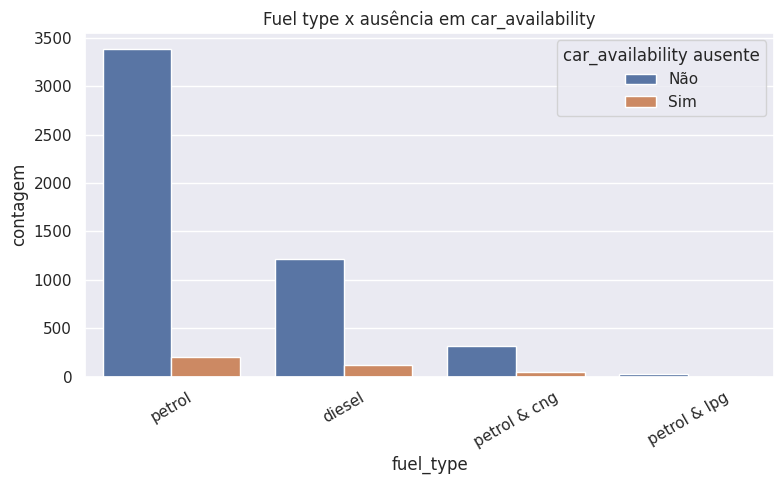

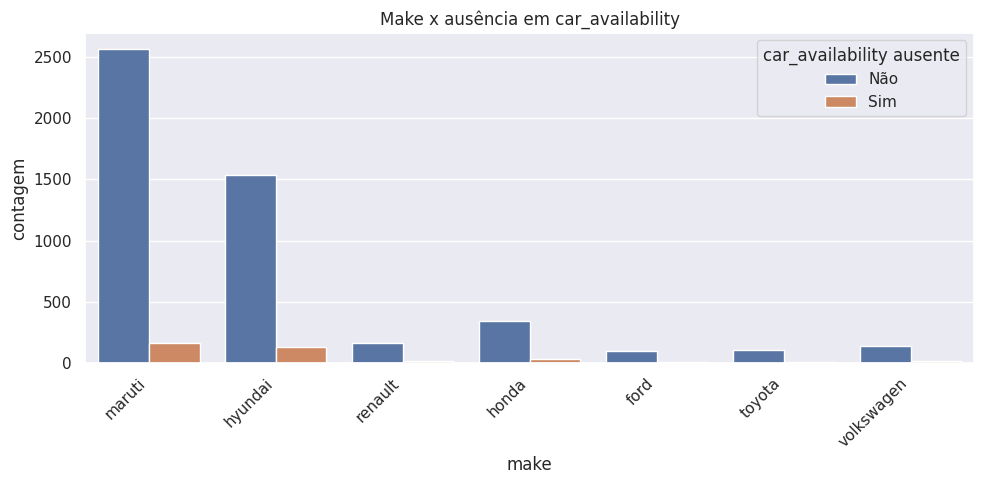

In [103]:
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1) Quantidade e percentual de valores ausentes
missing_count = df["car_availability"].isna().sum()
missing_pct = 100 * missing_count / len(df)

print(f"Valores ausentes em 'car_availability': {missing_count} ({missing_pct:.2f}%)")

# 2) Flag temporária de ausência
df["car_availability_missing"] = df["car_availability"].isna()

# 3) Qui-quadrado com fuel_type e make
for col in ["fuel_type", "make"]:
    ct = pd.crosstab(df[col], df["car_availability_missing"])
    chi2, p, dof, _ = chi2_contingency(ct)
    print(f"\nQui-quadrado entre 'car_availability_missing' e '{col}':")
    print(f"  chi2 = {chi2:.2f}, p = {p:.4f}, dof = {dof}")

# 4) Gráfico de barras para fuel_type
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="fuel_type", hue="car_availability_missing")
plt.title("Fuel type x ausência em car_availability")
plt.xlabel("fuel_type")
plt.ylabel("contagem")
plt.legend(title="car_availability ausente", labels=["Não", "Sim"])
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# 5) Gráfico de barras para make (opcional)
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="make", hue="car_availability_missing")
plt.title("Make x ausência em car_availability")
plt.xlabel("make")
plt.ylabel("contagem")
plt.legend(title="car_availability ausente", labels=["Não", "Sim"])
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 6) Remover flag temporária (apenas análise)
df.drop(columns=["car_availability_missing"], inplace=True)


### Imputação de `car_availability`

Após analisar a ausência em `car_availability`, vimos que cerca de 7% dos
registros não possuem esse campo preenchido e que a probabilidade de falta
depende de `fuel_type`, ou seja, a ausência não é MCAR.

Como `car_availability` é uma variável categórica (ex.: "Available", "Sold") e
pode ser usada como preditora em modelos futuros, optamos por não "chutar" um
status via modelos mais complexos. Em vez disso, tratamos a ausência como uma
categoria explícita, preenchendo os valores ausentes com `"unknown"`.

Dessa forma:

- não introduzimos vazamento de informação a partir de `sale_price` no processo
  de imputação;
- mantemos o padrão de ausência disponível para o modelo aprender (por exemplo,
  casos em que a disponibilidade não foi informada podem ter comportamento
  diferente);
- usamos uma estratégia simples e interpretável, adequada ao contexto do
  projeto.


In [104]:
fill_value_ca = "unknown"
missing_before_ca = df["car_availability"].isna().sum()
print(f"Valores ausentes em 'car_availability' ANTES: {missing_before_ca}")

df["car_availability"] = df["car_availability"].fillna(fill_value_ca)

missing_after_ca = df["car_availability"].isna().sum()
print(f"Valores ausentes em 'car_availability' DEPOIS: {missing_after_ca}")

Valores ausentes em 'car_availability' ANTES: 372
Valores ausentes em 'car_availability' DEPOIS: 0


## Analisar e tratar a coluna `body_type`

Medição de ausência, testes com variáveis categóricas/numéricas e imputação (moda) dada a baixa quantidade de `NaN`, registrando o raciocínio para transparência.

--- Análise e Tratamento da Coluna 'body_type' ---
Quantidade de valores ausentes na coluna 'body_type': 10
Percentual de valores ausentes na coluna 'body_type': 0.19%

Comparação da distribuição de variáveis categóricas pela ausência em 'body_type':
Teste Qui-Quadrado para 'fuel_type' vs Ausência em 'body_type':
Estatística Qui-Quadrado: 15.9941, Valor p: 0.0011
Associação estatisticamente significativa.

Teste Qui-Quadrado para 'make' vs Ausência em 'body_type':
Estatística Qui-Quadrado: 4.1243, Valor p: 0.6599
Sem associação estatisticamente significativa.


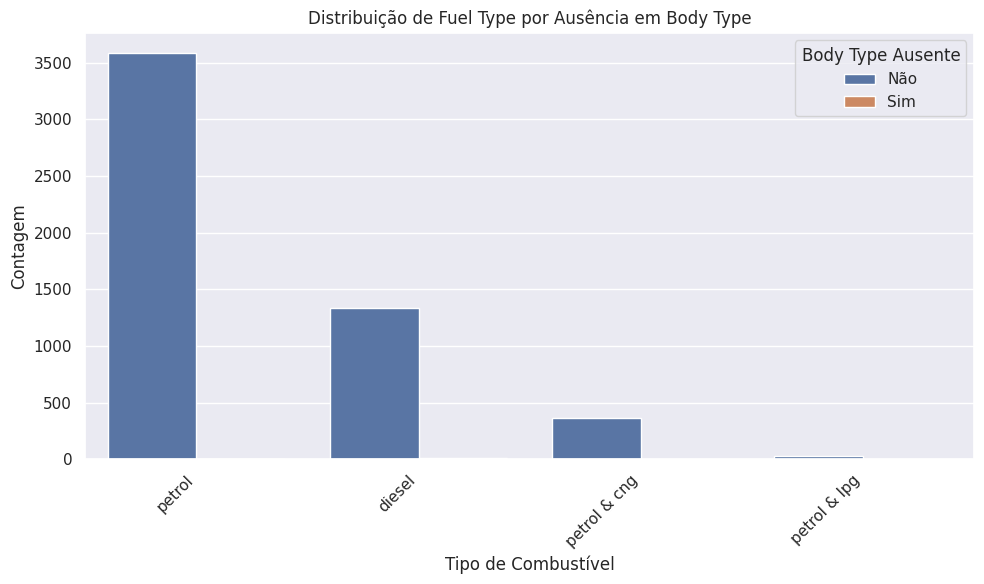

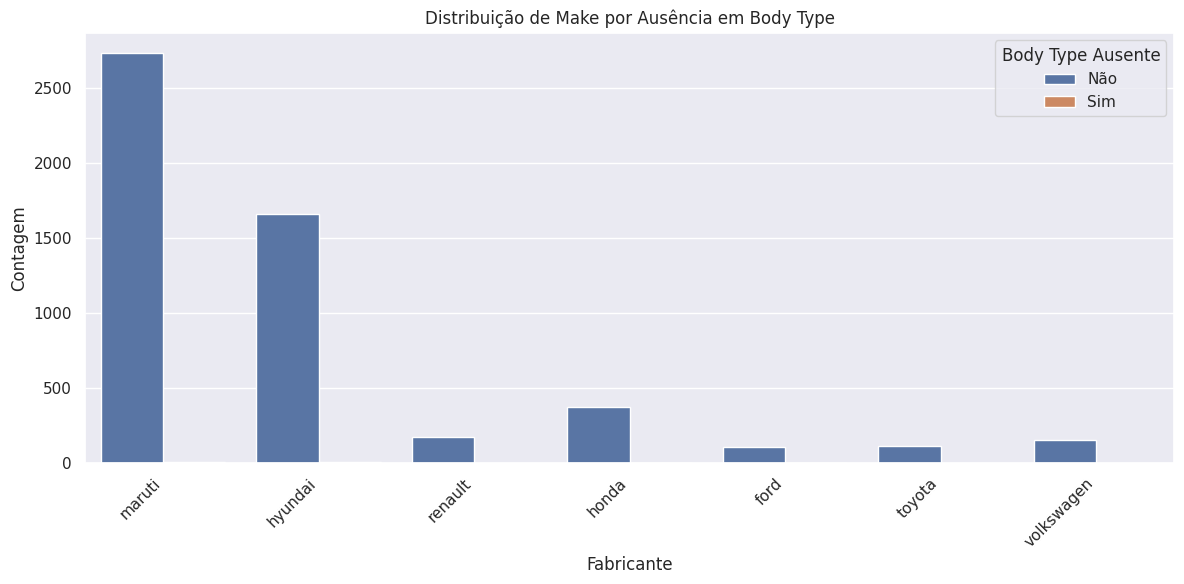


Comparação da distribuição de variáveis numéricas pela ausência em 'body_type':
Teste t de Welch para 'sale_price' vs Ausência em 'body_type':
Estatística t: -1.9126, Valor p: 0.0881
Sem diferença estatisticamente significativa na média.

Teste Mann-Whitney U para 'kms_run' vs Ausência em 'body_type':
Estatística: 30277.0000, Valor p: 0.4397
Sem diferença estatisticamente significativa na distribuição.


/tmp/ipykernel_1168/2326158988.py:110: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot_sale_price_bt, patch_artist=True, labels=['Com Body Type', 'Sem Body Type'])


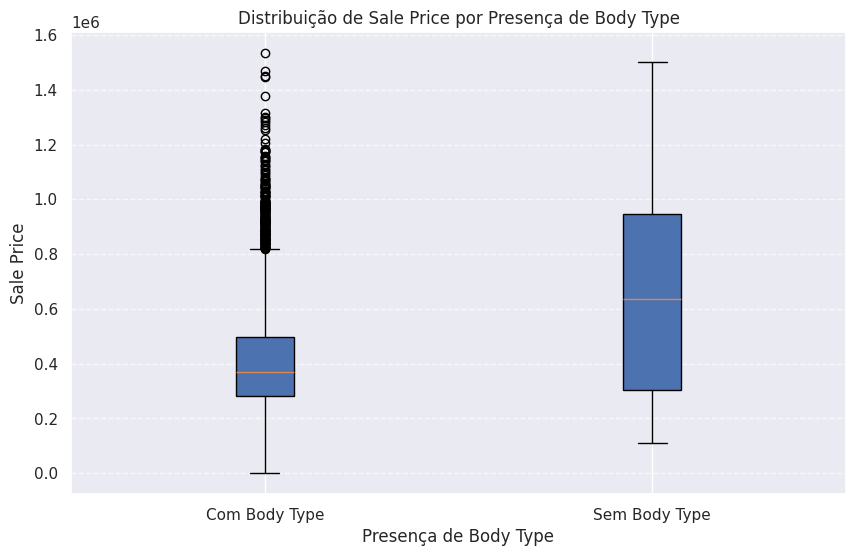

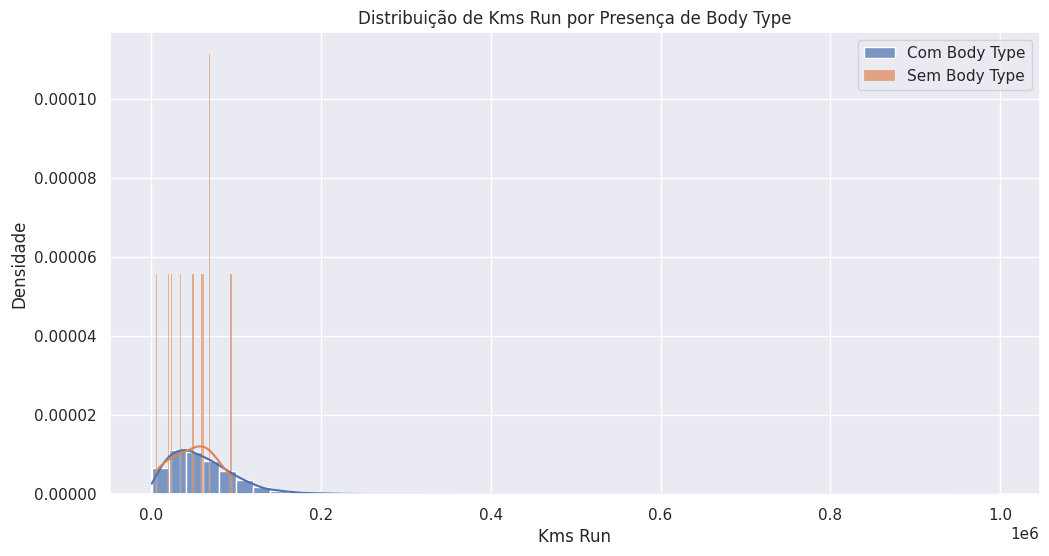


Classificação do tipo de ausência em 'body_type' e escolha do método de imputação:
A quantidade de valores ausentes em 'body_type' (10) é muito pequena.
Uma análise estatística robusta do tipo de ausência pode não ser possível ou necessária.
Considerando a baixa quantidade, a ausência é mais provável de ser MCAR ou MAR com pouca influência.
Para variáveis categóricas com poucos ausentes, a imputação pela moda é uma abordagem simples e razoável.

Imputação da coluna 'body_type' concluída usando a moda.
Quantidade de valores ausentes na coluna 'body_type' após imputação: 0

Colunas restantes com valores ausentes após tratamento de 'body_type':
registered_city         2
registered_state        2
source                 73
car_rating              2
fitness_certificate     5
dtype: int64


/tmp/ipykernel_1168/2326158988.py:159: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['body_type'].fillna(mode_body_type, inplace=True)


In [105]:
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Analisar e tratar a coluna 'body_type' ---
print("--- Análise e Tratamento da Coluna 'body_type' ---")

# 1. Determinar a quantidade e o percentual de valores ausentes na coluna 'body_type'
missing_body_type_count = df['body_type'].isnull().sum()
missing_body_type_percent = (missing_body_type_count / len(df)) * 100

print(f"Quantidade de valores ausentes na coluna 'body_type': {missing_body_type_count}")
print(f"Percentual de valores ausentes na coluna 'body_type': {missing_body_type_percent:.2f}%")

# 2. Analisar o tipo de ausência (MCAR, MAR, MNAR)
# Criar uma coluna booleana temporária indicando a ausência de valores na coluna 'body_type'
df['body_type_missing'] = df['body_type'].isnull()

# Comparar a distribuição de variáveis categóricas ('fuel_type', 'make')
print("\nComparação da distribuição de variáveis categóricas pela ausência em 'body_type':")

# Tabela de contingência com fuel_type
contingency_table_fuel_type_bt = pd.crosstab(df['fuel_type'], df['body_type_missing'])
# Teste qui- quadrado para fuel_type
chi2_fuel_type_bt, p_fuel_type_bt, dof_fuel_type_bt, expected_fuel_type_bt = chi2_contingency(contingency_table_fuel_type_bt)
print(f"Teste Qui-Quadrado para 'fuel_type' vs Ausência em 'body_type':")
print(f"Estatística Qui-Quadrado: {chi2_fuel_type_bt:.4f}, Valor p: {p_fuel_type_bt:.4f}")
if p_fuel_type_bt < 0.05:
    print("Associação estatisticamente significativa.")
else:
    print("Sem associação estatisticamente significativa.")

# Tabela de contingência com make
contingency_table_make_bt = pd.crosstab(df['make'], df['body_type_missing'])
# Teste qui-quadrado para make
chi2_make_bt, p_make_bt, dof_make_bt, expected_make_bt = chi2_contingency(contingency_table_make_bt)
print(f"\nTeste Qui-Quadrado para 'make' vs Ausência em 'body_type':")
print(f"Estatística Qui-Quadrado: {chi2_make_bt:.4f}, Valor p: {p_make_bt:.4f}")
if p_make_bt < 0.05:
    print("Associação estatisticamente significativa.")
else:
    print("Sem associação estatisticamente significativa.")

# Visualizar a distribuição de 'fuel_type' e 'make'
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='fuel_type', hue='body_type_missing')
plt.title('Distribuição de Fuel Type por Ausência em Body Type')
plt.xlabel('Tipo de Combustível')
plt.ylabel('Contagem')
plt.legend(title='Body Type Ausente', labels=['Não', 'Sim'])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='make', hue='body_type_missing')
plt.title('Distribuição de Make por Ausência em Body Type')
plt.xlabel('Fabricante')
plt.ylabel('Contagem')
plt.legend(title='Body Type Ausente', labels=['Não', 'Sim'])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Comparar a distribuição de variáveis numéricas ('sale_price', 'kms_run')
print("\nComparação da distribuição de variáveis numéricas pela ausência em 'body_type':")

# Criar sub-DataFrames
df_bt_present = df.dropna(subset=['body_type']).copy()
df_bt_missing = df[df['body_type'].isnull()].copy()

# Teste para 'sale_price'
if len(df_bt_present['sale_price']) > 1 and len(df_bt_missing['sale_price']) > 1:
    stat_sale_price_bt, p_value_sale_price_bt = stats.ttest_ind(
        df_bt_present['sale_price'],
        df_bt_missing['sale_price'],
        equal_var=False # Welch's t-test
    )
    print(f"Teste t de Welch para 'sale_price' vs Ausência em 'body_type':")
    print(f"Estatística t: {stat_sale_price_bt:.4f}, Valor p: {p_value_sale_price_bt:.4f}")
    if p_value_sale_price_bt < 0.05:
        print("Diferença estatisticamente significativa na média.")
    else:
        print("Sem diferença estatisticamente significativa na média.")
else:
    print("Dados insuficientes em um ou ambos os grupos para Teste t em 'sale_price'.")


# Teste para 'kms_run'
if len(df_bt_present['kms_run']) > 0 and len(df_bt_missing['kms_run']) > 0:
    stat_kms_run_bt, p_value_kms_run_bt = stats.mannwhitneyu(
        df_bt_present['kms_run'].dropna(),
        df_bt_missing['kms_run'].dropna()
    )
    print(f"\nTeste Mann-Whitney U para 'kms_run' vs Ausência em 'body_type':")
    print(f"Estatística: {stat_kms_run_bt:.4f}, Valor p: {p_value_kms_run_bt:.4f}")
    if p_value_kms_run_bt < 0.05:
        print("Diferença estatisticamente significativa na distribuição.")
    else:
        print("Sem diferença estatisticamente significativa na distribuição.")
else:
     print("Dados insuficientes em um ou ambos os grupos para Teste Mann-Whitney U em 'kms_run'.")


# Visualizar a distribuição de 'sale_price' e 'kms_run'
plt.figure(figsize=(10, 6))
data_to_plot_sale_price_bt = [df_bt_present['sale_price'].dropna(), df_bt_missing['sale_price'].dropna()]
plt.boxplot(data_to_plot_sale_price_bt, patch_artist=True, labels=['Com Body Type', 'Sem Body Type'])
plt.title('Distribuição de Sale Price por Presença de Body Type')
plt.xlabel('Presença de Body Type')
plt.ylabel('Sale Price')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(df_bt_present['kms_run'].dropna(), bins=50, kde=True, alpha=0.7, label='Com Body Type', stat="density", common_norm=False)
sns.histplot(df_bt_missing['kms_run'].dropna(), bins=50, kde=True, alpha=0.7, label='Sem Body Type', stat="density", common_norm=False)
plt.xlabel('Kms Run')
plt.ylabel('Densidade')
plt.title('Distribuição de Kms Run por Presença de Body Type')
plt.legend()
plt.show()


# 3. Classificar o tipo de ausência e escolher o método de imputação
print("\nClassificação do tipo de ausência em 'body_type' e escolha do método de imputação:")

# Reavaliar a classificação com base nos p-valores
# Nota: Se houver poucos dados ausentes, os testes estatísticos podem não ser conclusivos.
# Neste caso, a análise da quantidade e o contexto do negócio são importantes.
missing_count_bt = df['body_type'].isnull().sum()

if missing_count_bt < 20: # Arbitrary threshold for "few" missing values
    print(f"A quantidade de valores ausentes em 'body_type' ({missing_count_bt}) é muito pequena.")
    print("Uma análise estatística robusta do tipo de ausência pode não ser possível ou necessária.")
    print("Considerando a baixa quantidade, a ausência é mais provável de ser MCAR ou MAR com pouca influência.")
    print("Para variáveis categóricas com poucos ausentes, a imputação pela moda é uma abordagem simples e razoável.")
    imputation_method_bt = 'mode'
else:
    is_associated_with_categorical_bt = p_fuel_type_bt < 0.05 or p_make_bt < 0.05
    is_associated_with_numerical_bt = (len(df_bt_present['sale_price']) > 1 and len(df_bt_missing['sale_price']) > 1 and p_value_sale_price_bt < 0.05) or \
                                   (len(df_bt_present['kms_run']) > 0 and len(df_bt_missing['kms_run']) > 0 and p_value_kms_run_bt < 0.05)

    if is_associated_with_categorical_bt or is_associated_with_numerical_bt:
        print("A ausência em 'body_type' parece ser Missing at Random (MAR) ou Missing Not at Random (MNAR), pois há associação/diferença significativa com outras variáveis observadas.")
        print("Como 'body_type' é uma variável categórica, a imputação pela moda é uma opção prática.")
        imputation_method_bt = 'mode'
    else:
        print("A ausência em 'body_type' parece ser Missing Completely at Random (MCAR).")
        print("Como 'body_type' é categórica, a imputação pela moda é uma abordagem comum para MCAR.")
        imputation_method_bt = 'mode'


# 4. Aplicar o método de imputação escolhido
if imputation_method_bt == 'mode':
    mode_body_type = df['body_type'].mode()[0]
    df['body_type'].fillna(mode_body_type, inplace=True)
    print(f"\nImputação da coluna 'body_type' concluída usando a moda.")

# 5. Confirmar a imputação
missing_values_after_bt_imputation = df['body_type'].isnull().sum()
print(f"Quantidade de valores ausentes na coluna 'body_type' após imputação: {missing_values_after_bt_imputation}")

# Remover a coluna temporária
if 'body_type_missing' in df.columns:
    df.drop('body_type_missing', axis=1, inplace=True)

# Verificar quais colunas ainda têm valores ausentes para a verificação final
missing_values_final_check = df.isnull().sum()
columns_with_missing_final_check = missing_values_final_check[missing_values_final_check > 0]

print("\nColunas restantes com valores ausentes após tratamento de 'body_type':")
print(columns_with_missing_final_check)

### Imputação de `registered_city` e `registered_state`

Restam poucos `NaN` nessas colunas; imputamos com a moda (categoria mais frequente) e checamos se o preenchimento removeu todas as faltas.

In [106]:
# --- Tratamento das colunas registered_city e registered_state ---
print("--- Tratamento das Colunas Restantes com Poucos Valores Ausentes ---")

cols_to_treat = ['registered_city', 'registered_state']

for col in cols_to_treat:
    print(f" Analisando e tratando a coluna: '{col}'")

    missing_count = df[col].isnull().sum()
    missing_percent = (missing_count / len(df)) * 100

    print(f"Quantidade de valores ausentes: {missing_count}")
    print(f"Percentual de valores ausentes: {missing_percent:.2f}%")

    if missing_count > 0:
        if df[col].dtype == 'object' or df[col].dtype == 'bool':
            mode_val = df[col].mode()[0]
            df[col].fillna(mode_val, inplace=True)
            print(f"Imputação da coluna '{col}' concluída usando a moda.")

    missing_after = df[col].isnull().sum()
    print(f"Quantidade de valores ausentes após imputação: {missing_after}")
    if missing_after == 0:
        print(f"Imputação na coluna '{col}' confirmada como bem-sucedida.")
    else:
        print(f"ATENÇÃO: Ainda existem valores ausentes na coluna '{col}'.")

missing_values_final = df.isnull().sum()
columns_with_missing_final = missing_values_final[missing_values_final > 0]

print("Colunas restantes com valores ausentes após este passo:")
print(columns_with_missing_final)


--- Tratamento das Colunas Restantes com Poucos Valores Ausentes ---
 Analisando e tratando a coluna: 'registered_city'
Quantidade de valores ausentes: 2
Percentual de valores ausentes: 0.04%
Imputação da coluna 'registered_city' concluída usando a moda.
Quantidade de valores ausentes após imputação: 0
Imputação na coluna 'registered_city' confirmada como bem-sucedida.
 Analisando e tratando a coluna: 'registered_state'
Quantidade de valores ausentes: 2
Percentual de valores ausentes: 0.04%
Imputação da coluna 'registered_state' concluída usando a moda.
Quantidade de valores ausentes após imputação: 0
Imputação na coluna 'registered_state' confirmada como bem-sucedida.
Colunas restantes com valores ausentes após este passo:
source                 73
car_rating              2
fitness_certificate     5
dtype: int64


/tmp/ipykernel_1168/839781086.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode_val, inplace=True)


## Verificação final de valores ausentes

Conferimos se ainda existe algum `NaN` depois de todas as imputações, antes de seguir para outliers/engenharia de features.

In [107]:
missing_summary = df.isnull().sum()
print(missing_summary[missing_summary > 0])

source                 73
car_rating              2
fitness_certificate     5
dtype: int64


## 5. Tratamento de outliers

Aplicamos capping para reduzir a influência de valores extremos: IQR para `original_price`, `kms_run`, `times_viewed`; e percentis por grupo (make × fuel_type) para `sale_price`. Preferimos limitar, não remover, para preservar registros de alto valor.

--- Tratamento de Outliers para 'original_price' ---
Q1: 331349.00 | Q3: 555065.75 | IQR: 223716.75 | Limite superior: 890640.88
Outliers acima do limite em 'original_price': 407
Capping aplicado em 'original_price'.


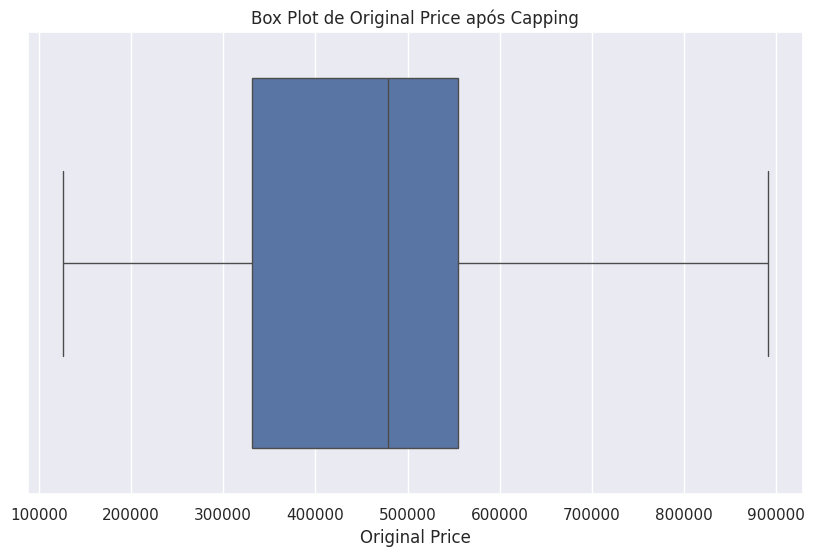

NaNs em 'original_price' após capping: 0


In [108]:
# --- Tratamento de Outliers para 'original_price' ---
print("--- Tratamento de Outliers para 'original_price' ---")

Q1 = df['original_price'].quantile(0.25)
Q3 = df['original_price'].quantile(0.75)
IQR = Q3 - Q1
upper_limit_original_price = Q3 + 1.5 * IQR

outliers_count = df[df['original_price'] > upper_limit_original_price].shape[0]
print(f"Q1: {Q1:.2f} | Q3: {Q3:.2f} | IQR: {IQR:.2f} | Limite superior: {upper_limit_original_price:.2f}")
print(f"Outliers acima do limite em 'original_price': {outliers_count}")

# Capping
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df['original_price'] = np.where(df['original_price'] > upper_limit_original_price,
                               upper_limit_original_price,
                               df['original_price'])
print("Capping aplicado em 'original_price'.")

# Boxplot após capping
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['original_price'])
plt.title('Box Plot de Original Price após Capping')
plt.xlabel('Original Price')
plt.show()

print("NaNs em 'original_price' após capping:", df['original_price'].isnull().sum())


### Capping global de `kms_run` e `times_viewed`

Usamos IQR (Q3 ± 1,5×IQR) para cortar caudas em quilometragem e visualizações, reduzindo a distorção de pontos muito fora do padrão.

kms_run: Q1=31397.00, Q3=82343.75, IQR=50946.75, lower=-45023.12, upper=158763.88
Outliers acima: 130, abaixo: 0
Capping aplicado em kms_run. NaNs: 0


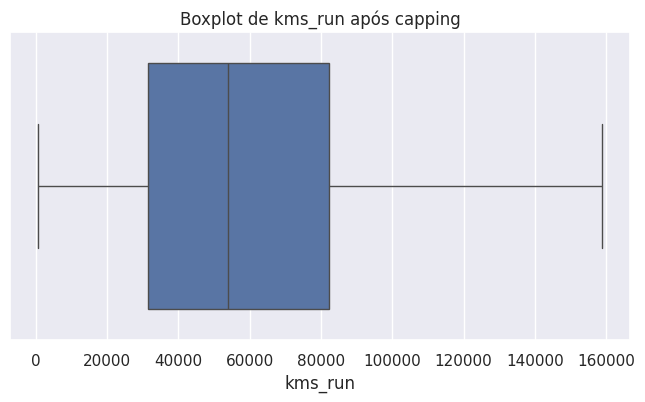

times_viewed: Q1=521.75, Q3=1720.00, IQR=1198.25, lower=-1275.62, upper=3517.38
Outliers acima: 286, abaixo: 0
Capping aplicado em times_viewed. NaNs: 0


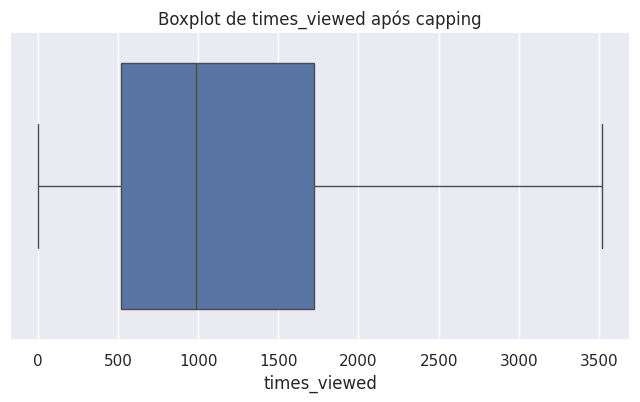

In [109]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

for col in ['kms_run', 'times_viewed']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    upper = Q3 + 1.5 * IQR
    lower = Q1 - 1.5 * IQR
    count_upper = (df[col] > upper).sum()
    count_lower = (df[col] < lower).sum()
    print(f"{col}: Q1={Q1:.2f}, Q3={Q3:.2f}, IQR={IQR:.2f}, lower={lower:.2f}, upper={upper:.2f}")
    print(f"Outliers acima: {count_upper}, abaixo: {count_lower}")

    df[col] = np.where(df[col] > upper, upper, df[col])
    df[col] = np.where(df[col] < lower, lower, df[col])
    print(f"Capping aplicado em {col}. NaNs: {df[col].isnull().sum()}")

    plt.figure(figsize=(8,4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot de {col} após capping')
    plt.xlabel(col)
    plt.show()


### Análise de outliers e capping de `sale_price`

Boxplots por `fuel_type` e `make` identificam grupos com extremos; em seguida aplicamos capping por grupo (percentis 1 e 99) para preservar diferenças entre categorias.

--- Análise de Outliers para 'sale_price' por Fuel Type e Make ---


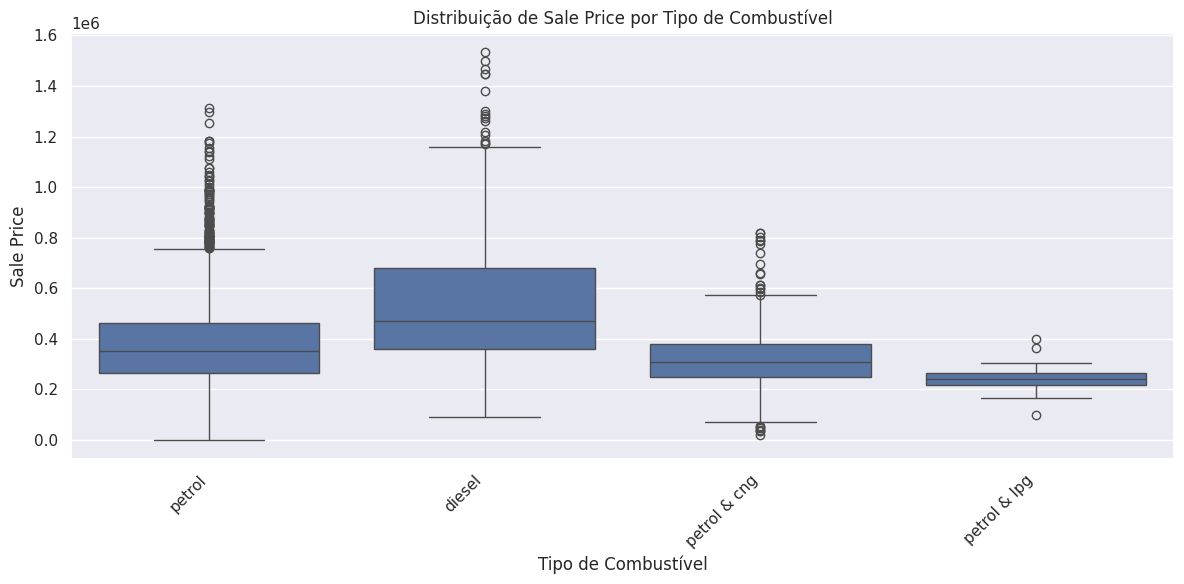

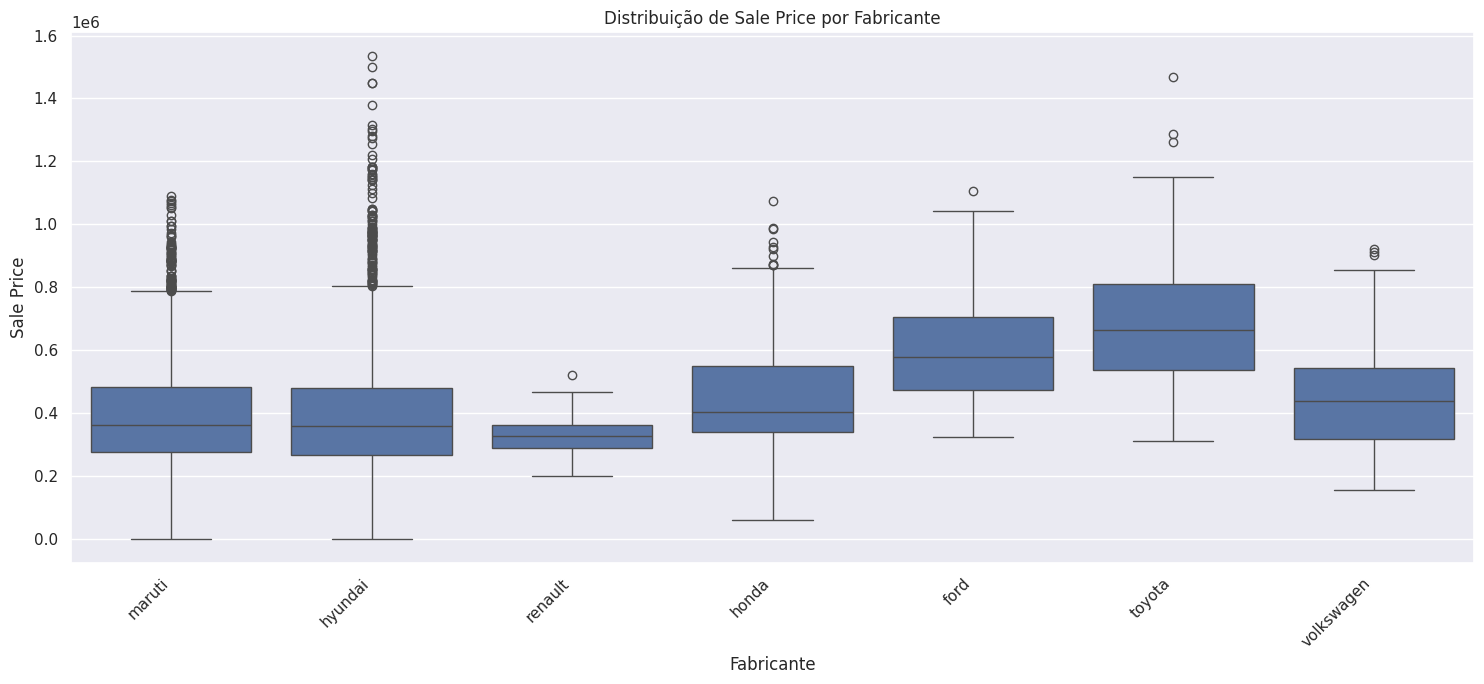

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Análise de Outliers para 'sale_price' por Fuel Type e Make ---")

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='fuel_type', y='sale_price')
plt.title('Distribuição de Sale Price por Tipo de Combustível')
plt.xlabel('Tipo de Combustível')
plt.ylabel('Sale Price')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 7))
sns.boxplot(data=df, x='make', y='sale_price')
plt.title('Distribuição de Sale Price por Fabricante')
plt.xlabel('Fabricante')
plt.ylabel('Sale Price')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


--- Tratamento de Outliers para 'sale_price' (Capping por Make e Fuel Type - Percentis 1 e 99) ---
Capping por grupo concluído.
Estatísticas de 'sale_price' antes e depois do capping:
Antes:
count    5.316000e+03
mean     4.142918e+05
std      1.921765e+05
min      0.000000e+00
25%      2.824990e+05
50%      3.702490e+05
75%      4.978240e+05
max      1.533481e+06
Name: sale_price, dtype: float64
Depois:
count    5.316000e+03
mean     4.137347e+05
std      1.884985e+05
min      3.770000e+04
25%      2.824990e+05
50%      3.702490e+05
75%      4.975740e+05
max      1.441376e+06
Name: sale_price, dtype: float64


/tmp/ipykernel_1168/3978395750.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '733526.9999999987' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_capped.loc[mask & (df_capped['sale_price'] > high), 'sale_price'] = high


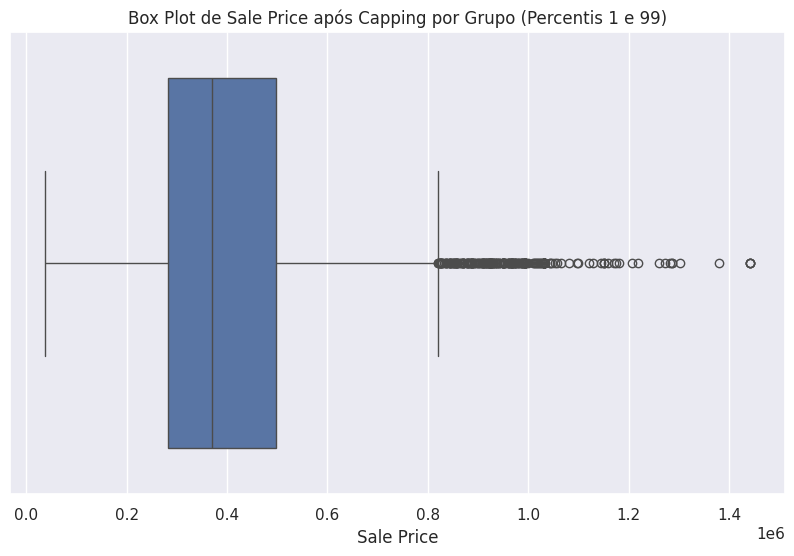

NaNs em 'sale_price' após capping: 0


In [111]:
# --- Tratamento de Outliers para 'sale_price' (Capping por Make e Fuel Type - Percentis 1 e 99) ---
print("--- Tratamento de Outliers para 'sale_price' (Capping por Make e Fuel Type - Percentis 1 e 99) ---")

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df_capped = df.copy()
grouping_cols = ['make', 'fuel_type']
low_p = 0.01
high_p = 0.99

for make, fuel in df_capped[grouping_cols].drop_duplicates().values:
    mask = (df_capped['make'] == make) & (df_capped['fuel_type'] == fuel)
    grp = df_capped.loc[mask, 'sale_price']
    if len(grp) < 10:
        continue
    low = grp.quantile(low_p)
    high = grp.quantile(high_p)
    df_capped.loc[mask & (df_capped['sale_price'] < low), 'sale_price'] = low
    df_capped.loc[mask & (df_capped['sale_price'] > high), 'sale_price'] = high

print("Capping por grupo concluído.")
print("Estatísticas de 'sale_price' antes e depois do capping:")
print("Antes:")
print(df['sale_price'].describe())
print("Depois:")
print(df_capped['sale_price'].describe())

plt.figure(figsize=(10, 6))
sns.boxplot(x=df_capped['sale_price'])
plt.title('Box Plot de Sale Price após Capping por Grupo (Percentis 1 e 99)')
plt.xlabel('Sale Price')
plt.show()

# Atualizar df principal
df['sale_price'] = df_capped['sale_price']
print("NaNs em 'sale_price' após capping:", df['sale_price'].isnull().sum())


## 6. Engenharia de features

Criamos variáveis derivadas para capturar aspectos de ciclo de vida e uso do veículo antes da modelagem:
- `car_age`: idade calculada a partir de `yr_mfr`.
- `kms_per_year`: intensidade média de uso (km rodados divididos pela idade, com ajuste para divisão por zero e substituição de inf/NaN pela mediana).
- `depreciation`: diferença absoluta entre `original_price` imputado e `sale_price`, refletindo desvalorização.
Essas features alimentam os modelos e ajudam na interpretação dos fatores de preço.

In [112]:
from datetime import datetime
import numpy as np

# Criar features derivadas
current_year = datetime.now().year

# Idade do carro
df['car_age'] = current_year - df['yr_mfr']

# Quilometragem por ano
df['kms_per_year'] = df['kms_run'] / (df['car_age'] + 1e-6)
df['kms_per_year'] = df['kms_per_year'].replace([np.inf, -np.inf], np.nan)
median_kms_per_year = df['kms_per_year'].median()
df['kms_per_year'] = df['kms_per_year'].fillna(median_kms_per_year)

# Depreciação absoluta
df['depreciation'] = df['original_price'] - df['sale_price']


## 7. EDA orientada à variável alvo

Exploramos como `sale_price` se relaciona com as features derivadas (`car_age`, `kms_per_year`, `depreciation`), buscando tendências de preço com idade/uso e sinais de assimetria ou outliers.

### Visualização das novas features

Histogramas e dispersões de `car_age`, `kms_per_year` e `depreciation` versus `sale_price` para enxergar distribuição, correlação visual e necessidade de transformações futuras (log/capping).

--- Análise Visual das Features de Engenharia ---


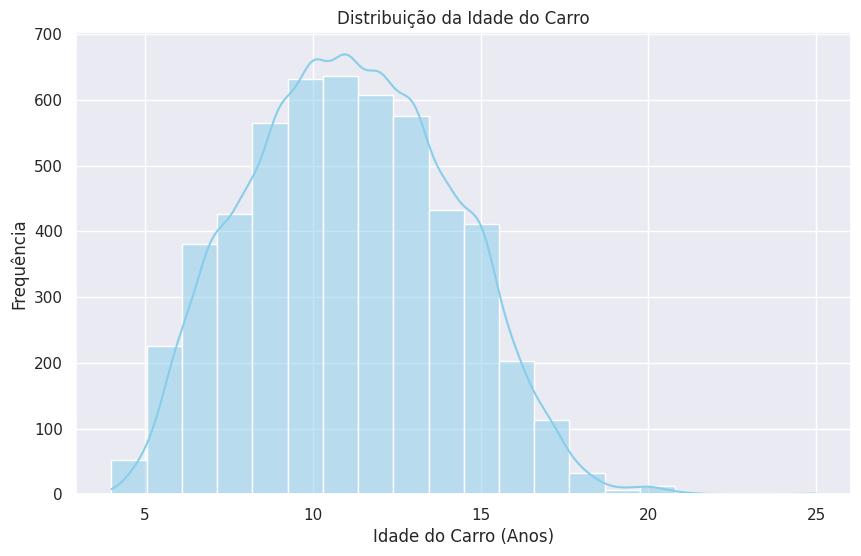

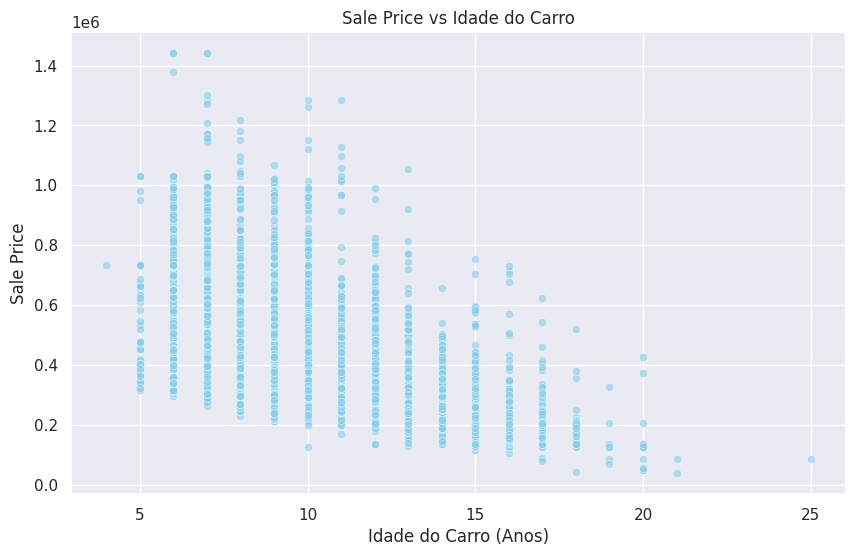

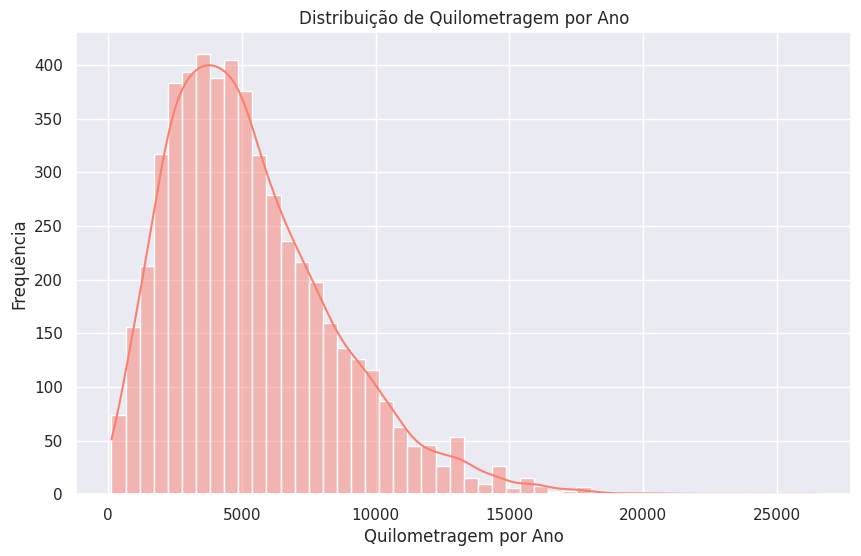

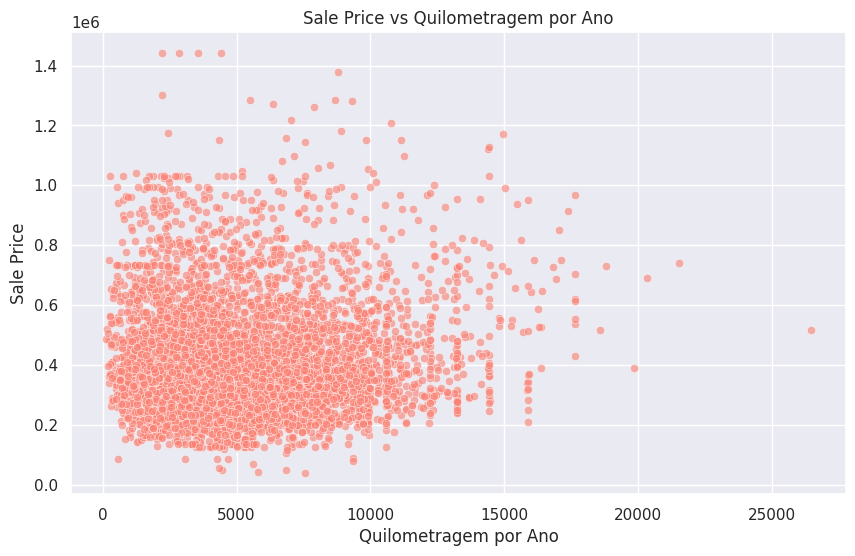

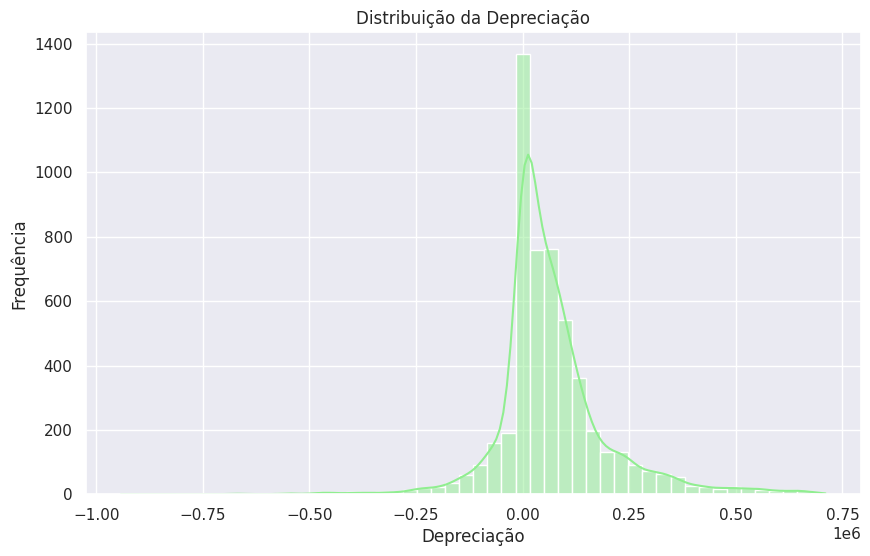

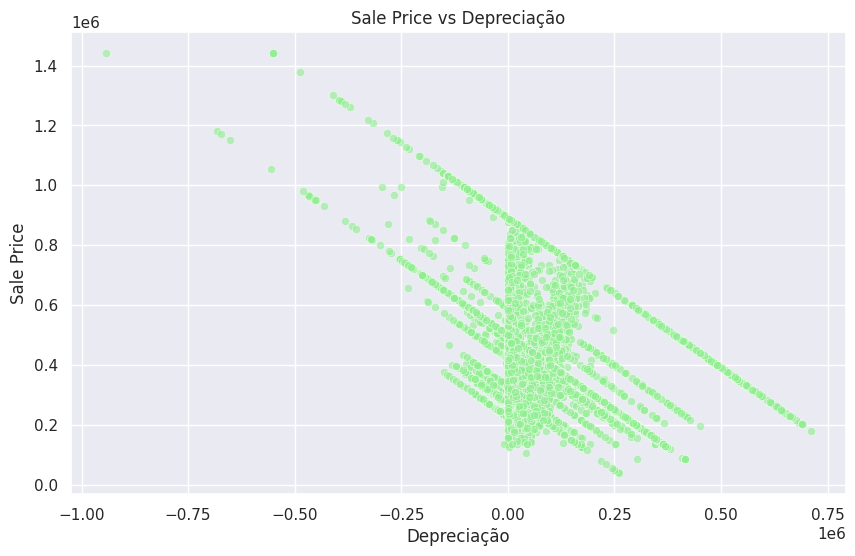

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Análise Visual das Features de Engenharia ---")

# Histograma para 'car_age'
plt.figure(figsize=(10, 6))
sns.histplot(df['car_age'], bins=20, kde=True, color='skyblue')
plt.title('Distribuição da Idade do Carro')
plt.xlabel('Idade do Carro (Anos)')
plt.ylabel('Frequência')
plt.show()

# Scatter plot: 'car_age' vs 'sale_price'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='car_age', y='sale_price', alpha=0.6, color='skyblue')
plt.title('Sale Price vs Idade do Carro')
plt.xlabel('Idade do Carro (Anos)')
plt.ylabel('Sale Price')
plt.grid(True)
plt.show()

# Histograma para 'kms_per_year'
plt.figure(figsize=(10, 6))
sns.histplot(df['kms_per_year'], bins=50, kde=True, color='salmon')
plt.title('Distribuição de Quilometragem por Ano')
plt.xlabel('Quilometragem por Ano')
plt.ylabel('Frequência')
plt.show()

# Scatter plot: 'kms_per_year' vs 'sale_price'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='kms_per_year', y='sale_price', alpha=0.6, color='salmon')
plt.title('Sale Price vs Quilometragem por Ano')
plt.xlabel('Quilometragem por Ano')
plt.ylabel('Sale Price')
plt.grid(True)
plt.show()

# Histograma para 'depreciation'
plt.figure(figsize=(10, 6))
sns.histplot(df['depreciation'], bins=50, kde=True, color='lightgreen')
plt.title('Distribuição da Depreciação')
plt.xlabel('Depreciação')
plt.ylabel('Frequência')
plt.show()

# Scatter plot: 'depreciation' vs 'sale_price'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='depreciation', y='sale_price', alpha=0.6, color='lightgreen')
plt.title('Sale Price vs Depreciação')
plt.xlabel('Depreciação')
plt.ylabel('Sale Price')
plt.grid(True)
plt.show()


## 8. Split e pré-processamento

Definimos features, excluímos alvo/colunas auxiliares, separamos treino/teste (80/20) e montamos um `ColumnTransformer` com `StandardScaler` para numéricas e `OneHotEncoder` para categóricas. Esse `preprocessor` alimenta os modelos subsequentes.

In [114]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
from datetime import datetime

# 2. Pré-processamento de Dados

# Excluir colunas que não são features (e.g., 'sale_price', 'car_name', 'variant', 'ad_created_on', 'rto', 'model', 'city', 'registered_city', 'registered_state')
columns_to_exclude = ['sale_price', 'depreciation', 'is_hot',
                      'booking_down_pymnt', 'broker_quote',
                      'reserved', 'emi_starts_from', 'assured_buy', 'rto',
                      'car_availability']
all_features = df.columns.tolist()
features_for_model = [col for col in all_features if col not in columns_to_exclude]

# Separar features categóricas e numéricas do conjunto de features para o modelo
categorical_features = df[features_for_model].select_dtypes(include=['object', 'bool']).columns.tolist()
numeric_features = df[features_for_model].select_dtypes(include=np.number).columns.tolist()


# Criar pipelines de pré-processamento para colunas numéricas e categóricas
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()) # Escalar features numéricas
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # Codificar features categóricas
])

# Criar um pré-processador que aplica as transformações apropriadas a cada tipo de coluna
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Manter outras colunas
)


# 3. Divisão dos Dados (conforme Passo 3 do plano)
X = df[features_for_model] # Features selecionadas
y = df['sale_price'] # Variável alvo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Dados divididos em treino e teste.")
print(f"Tamanho do conjunto de treino: {X_train.shape}")
print(f"Tamanho do conjunto de teste: {X_test.shape}")


Dados divididos em treino e teste.
Tamanho do conjunto de treino: (4252, 22)
Tamanho do conjunto de teste: (1064, 22)


## 9. Modelagem com Random Search (RF e Regressão Linear)

Pipeline com `preprocessor` + modelo e `RandomizedSearchCV` testando RandomForest e Linear Regression. Relatamos melhores hiperparâmetros, métricas no teste e um exemplo de predição para ilustrar o resultado.

In [115]:
# 4. Seleção e Treinamento do Modelo com Random Search

# Definir os modelos e o espaço de hiperparâmetros para o Random Search
# Podemos incluir diferentes modelos e seus respectivos hiperparâmetros
param_dist = [
    {
        'model': [RandomForestRegressor(random_state=42)], # Especifica RandomForestRegressor
        'model__n_estimators': [100, 200, 300], # Hiperparâmetros para RandomForest
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    },
    {
        'model': [LinearRegression()], # Especifica LinearRegression
        'model__fit_intercept': [True, False] # Hiperparâmetros para LinearRegression
    }
]


# Criar um pipeline que inclui o pré-processamento e o modelo
# O nome do estimador no pipeline deve ser 'model' para corresponder ao param_dist
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', RandomForestRegressor(random_state=42)) # Modelo placeholder inicial
                          ])

# Configurar o RandomizedSearchCV
# n_iter: número de combinações de hiperparâmetros a serem amostradas
# cv: número de folds para cross-validation
# scoring: métrica a ser otimizada (por exemplo, 'neg_mean_squared_error' para RMSE)
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)

# Executar o Random Search nos dados de treino
print("Executando Random Search...")
random_search.fit(X_train, y_train)

print("Random Search concluído.")

# Exibir os melhores hiperparâmetros encontrados
print("Melhores hiperparâmetros encontrados:")
print(random_search.best_params_)

# Exibir a melhor pontuação (RMSE)
print(f"Melhor pontuação (Negative Mean Squared Error): {random_search.best_score_:.4f}")
print(f"Melhor pontuação (RMSE): {np.sqrt(-random_search.best_score_):.4f}")

# O melhor modelo treinado está disponível em random_search.best_estimator_
best_model = random_search.best_estimator_
print("Melhor modelo treinado:")
print(best_model)


Executando Random Search...


KeyboardInterrupt: 

--- Métricas de Avaliação do Modelo no Conjunto de Teste ---
Mean Squared Error (MSE): 2359953636.2933
Root Mean Squared Error (RMSE): 48579.3540
Mean Absolute Error (MAE): 32741.9736
R-squared (R²): 0.9322


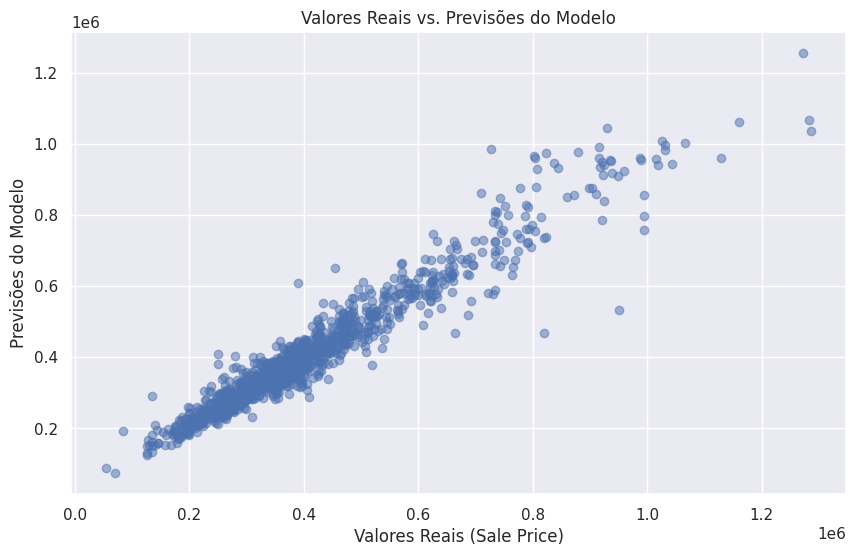

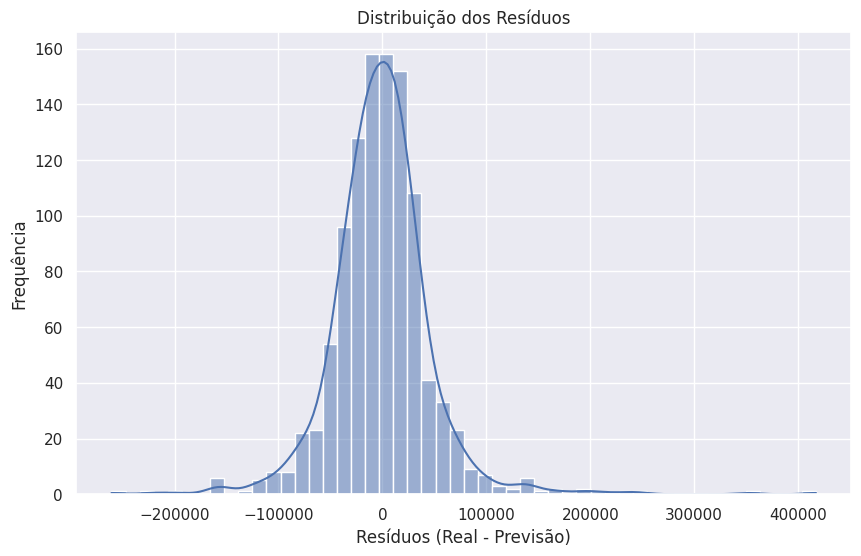

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# O melhor modelo treinado está armazenado em random_search.best_estimator_
best_model = random_search.best_estimator_

# Fazer previsões no conjunto de teste
y_pred = best_model.predict(X_test)

# Avaliar o modelo usando métricas de regressão
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("--- Métricas de Avaliação do Modelo no Conjunto de Teste ---")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Opcional: Visualizar as previsões vs. valores reais
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Valores Reais (Sale Price)")
plt.ylabel("Previsões do Modelo")
plt.title("Valores Reais vs. Previsões do Modelo")
plt.grid(True)
plt.show()

# Opcional: Visualizar a distribuição dos resíduos (erros de previsão)
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=50, kde=True)
plt.xlabel("Resíduos (Real - Previsão)")
plt.ylabel("Frequência")
plt.title("Distribuição dos Resíduos")
plt.show()


In [ ]:
# Selecionar um exemplo de carro do conjunto de teste para demonstração
# Vamos pegar a primeira linha do conjunto de teste original (antes do pré-processamento)
sample_car_features_df = X_test.iloc[[0]]

# Converter a linha do DataFrame para um dicionário para facilitar o acesso aos valores
sample_car_features_dict = sample_car_features_df.to_dict('records')[0]

# O melhor modelo (pipeline) já inclui o pré-processamento
predicted_price = best_model.predict(sample_car_features_df)

# Obter o valor real para comparação (opcional, já que é um exemplo do conjunto de teste)
real_price = y_test.iloc[0]

# Exibir os detalhes do carro e a previsão
print("--- Detalhes do Carro para Predição ---")
# Acessar e exibir algumas das features mais relevantes do carro de exemplo usando o dicionário
print(f"Modelo do Carro: {sample_car_features_dict.get('model', 'N/A')}") # Usar .get() para segurança
print(f"Ano de Fabricação: {sample_car_features_dict.get('yr_mfr', 'N/A')}")
print(f"Tipo de Combustível: {sample_car_features_dict.get('fuel_type', 'N/A')}")
print(f"Quilometragem: {sample_car_features_dict.get('kms_run', 0):,.0f} km".replace(',', '.'))
print(f"Tipo de Carroceria: {sample_car_features_dict.get('body_type', 'N/A')}")
print(f"Transmissão: {sample_car_features_dict.get('transmission', 'N/A')}")
# Acessar original_price
print(f"Preço Original (Imputado): {sample_car_features_dict.get('original_price', 0):,.0f}".replace(',', '.'))


print("--- Resultado da Predição ---")
print(f"O modelo de predição, baseado nas características fornecidas, estima o valor de venda em aproximadamente: {predicted_price[0]:,.2f}".replace(',', '.'))

# Comparação com o valor real (se disponível)
print(f"Valor de Venda Real (do conjunto de teste): {real_price:,.2f}".replace(',', '.'))
print(f"Diferença (Real - Predição): {real_price - predicted_price[0]:,.2f}".replace(',', '.'))


--- Detalhes do Carro para Predição ---
Modelo do Carro: grand i10
Ano de Fabricação: 2017
Tipo de Combustível: petrol
Quilometragem: 44.311 km
Tipo de Carroceria: hatchback
Transmissão: manual
Preço Original (Imputado): 499.333
--- Resultado da Predição ---
O modelo de predição. baseado nas características fornecidas. estima o valor de venda em aproximadamente: 433.023.59
Valor de Venda Real (do conjunto de teste): 406.399.00
Diferença (Real - Predição): -26.624.59


## 10. Seleção e treinamento com Gradient Boosting (Random Search)

Repetimos o fluxo com `GradientBoostingRegressor`, refazendo pré-processamento/split para garantir independência, ajustando hiperparâmetros via `RandomizedSearchCV` e avaliando desempenho e predições.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np

# --- Início: Re-definição de pré-processamento e dados de treino para garantir a execução independente ---
# Essas partes são replicadas de células anteriores para evitar NameError caso o ambiente seja resetado

# Excluir colunas que não são features
columns_to_exclude = ['sale_price', 'depreciation', 'is_hot',
                      'booking_down_pymnt', 'broker_quote',
                      'reserved', 'emi_starts_from', 'assured_buy', 'rto']
all_features = df.columns.tolist()
features_for_model = [col for col in all_features if col not in columns_to_exclude]

# Separar features categóricas e numéricas
categorical_features = df[features_for_model].select_dtypes(include=['object', 'bool']).columns.tolist()
numeric_features = df[features_for_model].select_dtypes(include=np.number).columns.tolist()

# Criar pipelines de pré-processamento
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()) # Escalar features numéricas
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # Codificar features categóricas
])

# Criar um pré-processador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# Divisão dos Dados
X = df[features_for_model] # Features selecionadas
y = df['sale_price'] # Variável alvo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# --- Fim: Re-definição de pré-processamento e dados de treino ---


# Definir o espaço de hiperparâmetros para o GradientBoostingRegressor
param_dist_gb = {
    'model': [GradientBoostingRegressor(random_state=42)], # Especifica GradientBoostingRegressor
    'model__n_estimators': [100, 200, 300], # Número de árvores
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2], # Taxa de aprendizado
    'model__max_depth': [3, 5, 8, 10], # Profundidade máxima de cada árvore
    'model__min_samples_split': [2, 5, 10], # Mínimo de amostras para dividir um nó interno
    'model__min_samples_leaf': [1, 2, 4] # Mínimo de amostras em uma folha
}

# Criar um pipeline que inclui o pré-processamento e o modelo Gradient Boosting
pipeline_gb = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', GradientBoostingRegressor(random_state=42)) # Modelo placeholder inicial
                             ])

# Configurar o RandomizedSearchCV para Gradient Boosting
# 'n_iter' controla o número de combinações de hiperparâmetros a serem testadas aleatoriamente
# 'cv' define o número de folds para validação cruzada
# 'scoring' define a métrica de avaliação (neg_mean_squared_error para RMSE)
random_search_gb = RandomizedSearchCV(pipeline_gb, param_distributions=param_dist_gb, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)

# Executar o Random Search nos dados de treino
print("Executando Random Search para Gradient Boosting...")
random_search_gb.fit(X_train, y_train)

print("Random Search para Gradient Boosting concluído.")

# Exibir os melhores hiperparâmetros encontrados
print("Melhores hiperparâmetros encontrados para Gradient Boosting:")
print(random_search_gb.best_params_)

# Exibir a melhor pontuação (RMSE) da validação cruzada
print(f"Melhor pontuação (Negative Mean Squared Error) para Gradient Boosting: {random_search_gb.best_score_:.4f}")
print(f"Melhor pontuação (RMSE) para Gradient Boosting: {np.sqrt(-random_search_gb.best_score_):.4f}")

# O melhor modelo treinado está disponível em random_search_gb.best_estimator_
best_model_gb = random_search_gb.best_estimator_
print("Melhor modelo de Gradient Boosting treinado:")
print(best_model_gb)


Executando Random Search para Gradient Boosting...


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# O melhor modelo treinado de Gradient Boosting está disponível em random_search_gb.best_estimator_
best_model_gb = random_search_gb.best_estimator_

# Fazer previsões no conjunto de teste
y_pred_gb = best_model_gb.predict(X_test)

# Avaliar o modelo usando métricas de regressão
mse_gb = mean_squared_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mse_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print("--- Métricas de Avaliação do Modelo Gradient Boosting no Conjunto de Teste ---")
print(f"Mean Squared Error (MSE): {mse_gb:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_gb:.4f}")
print(f"Mean Absolute Error (MAE): {mae_gb:.4f}")
print(f"R-squared (R²): {r2_gb:.4f}")

# Opcional: Visualizar as previsões vs. valores reais
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_gb, alpha=0.5)
plt.xlabel("Valores Reais (Sale Price)")
plt.ylabel("Previsões do Modelo Gradient Boosting")
plt.title("Valores Reais vs. Previsões do Modelo Gradient Boosting")
plt.grid(True)
plt.show()

# Opcional: Visualizar a distribuição dos resíduos (erros de previsão)
residuals_gb = y_test - y_pred_gb
plt.figure(figsize=(10, 6))
sns.histplot(residuals_gb, bins=50, kde=True)
plt.xlabel("Resíduos (Real - Previsão)")
plt.ylabel("Frequência")
plt.title("Distribuição dos Resíduos do Modelo Gradient Boosting")
plt.show()

# --- Hiperparâmetros Utilizados no Melhor Modelo Gradient Boosting ---
print("--- Hiperparâmetros Utilizados no Melhor Modelo Gradient Boosting ---")
model_params = best_model_gb.get_params()
filtered_params = {k.replace('model__', ''): v for k, v in model_params.items() if k.startswith('model__')}
for param, value in filtered_params.items():
    print(f"  {param}: {value}")

# --- Teste de Previsão para um Carro Específico com Gradient Boosting ---
print("--- Teste de Previsão para um Carro Específico (Gradient Boosting) ---")

sample_car_features_gb_df = X_test.iloc[[0]]
sample_car_features_gb_dict = sample_car_features_gb_df.to_dict('records')[0]

predicted_price_gb = best_model_gb.predict(sample_car_features_gb_df)
real_price_gb = y_test.iloc[0]

print("Detalhes do Carro para Predição:")
print(f"  Carro: {sample_car_features_gb_dict.get('car_name', 'N/A')}")
print(f"  Modelo: {sample_car_features_gb_dict.get('model', 'N/A')}")
print(f"  Ano de Fabricação: {sample_car_features_gb_dict.get('yr_mfr', 'N/A')}")
print(f"  Tipo de Combustível: {sample_car_features_gb_dict.get('fuel_type', 'N/A')}")
print(f"  Quilometragem: {sample_car_features_gb_dict.get('kms_run', 0):,.0f} km".replace(',', '.'))
print(f"  Tipo de Carroceria: {sample_car_features_gb_dict.get('body_type', 'N/A')}")
print(f"  Transmissão: {sample_car_features_gb_dict.get('transmission', 'N/A')}")
print(f"  Preço Original (Imputado/Capped): {sample_car_features_gb_dict.get('original_price', 0):,.0f}".replace(',', '.'))

print("Resultado da Predição:")
print(f"O modelo de predição (Gradient Boosting) estima o valor de venda em aproximadamente: {predicted_price_gb[0]:,.2f} ".replace(',', '.'))
print(f"Valor de Venda Real (do conjunto de teste): {real_price_gb:,.2f}".replace(',', '.'))
print(f"Diferença (Real - Predição): {real_price_gb - predicted_price_gb[0]:,.2f}".replace(',', '.'))


## Importância das Features para o Modelo Gradient Boosting

Visualizamos as top features do melhor modelo Gradient Boosting para entender quais variáveis mais pesam na previsão de preço.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Obter o melhor modelo Gradient Boosting (pipeline)
best_model_gb = random_search_gb.best_estimator_

# Acessar o regressor dentro do pipeline
gb_model = best_model_gb.named_steps['model']

# Obter as importâncias das features
feature_importances = gb_model.feature_importances_

# Obter os nomes das features após o pré-processamento (OneHotEncoder)
# Primeiro, obter os nomes das features numéricas
numeric_feature_names = best_model_gb.named_steps['preprocessor'].transformers_[0][2]

# Em seguida, obter os nomes das features categóricas após o OneHotEncoding
cat_pipeline = best_model_gb.named_steps['preprocessor'].transformers_[1][1]
onehot_encoder = cat_pipeline.named_steps['onehot']
categorical_feature_names = list(onehot_encoder.get_feature_names_out(best_model_gb.named_steps['preprocessor'].transformers_[1][2]))

# Combinar todos os nomes das features
all_feature_names = numeric_feature_names + categorical_feature_names

# Criar um DataFrame para visualização
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Visualizar as importâncias das features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Importância das Features para o Modelo Gradient Boosting')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("As importâncias das features foram calculadas e visualizadas.")


## 11. Modelo KNN com Random Search

Pipeline de pré-processamento + KNeighborsRegressor, hiperparâmetros buscados com `RandomizedSearchCV`, e avaliação completa (RMSE/MAE/R²) com gráficos de predição e resíduos.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
from datetime import datetime

# Pré-processamento de Dados (reexecução para garantir o estado do kernel)
columns_to_exclude = ['sale_price', 'depreciation', 'is_hot',
                      'booking_down_pymnt', 'broker_quote',
                      'reserved', 'emi_starts_from', 'assured_buy', 'rto',
                      'car_availability']
all_features = df.columns.tolist()
features_for_model = [col for col in all_features if col not in columns_to_exclude]

# Separar features categóricas e numéricas
categorical_features = df[features_for_model].select_dtypes(include=['object', 'bool']).columns.tolist()
numeric_features = df[features_for_model].select_dtypes(include=np.number).columns.tolist()

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# Divisão dos Dados
X = df[features_for_model]
y = df['sale_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Dados divididos em treino e teste.")
print(f"Tamanho do conjunto de treino: {X_train.shape}")
print(f"Tamanho do conjunto de teste: {X_test.shape}")

# Seleção e Treinamento do Modelo com Random Search
param_dist = [
    {
        'model': [KNeighborsRegressor()],
        'model__n_neighbors': [3, 5, 7, 9, 11],
        'model__weights': ['uniform', 'distance'],
        'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }
]

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', KNeighborsRegressor())])

random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)

print("Executando Random Search para KNeighborsRegressor...")
random_search.fit(X_train, y_train)
print("Random Search concluído.")

print("Melhores hiperparâmetros encontrados:")
print(random_search.best_params_)

print(f"Melhor pontuação (Negative Mean Squared Error): {random_search.best_score_:.4f}")
print(f"Melhor pontuação (RMSE): {np.sqrt(-random_search.best_score_):.4f}")

best_model_knn = random_search.best_estimator_
print("Melhor modelo treinado:")
print(best_model_knn)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

best_model_knn = random_search.best_estimator_

y_pred = best_model_knn.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("--- Métricas de Avaliação do Melhor Modelo KNN no Conjunto de Teste ---")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Valores Reais (Sale Price)")
plt.ylabel("Previsões do Modelo")
plt.title("Valores Reais vs. Previsões do Melhor Modelo KNN")
plt.grid(True)
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=50, kde=True)
plt.xlabel("Resíduos (Real - Previsão)")
plt.ylabel("Frequência")
plt.title("Distribuição dos Resíduos do Melhor Modelo KNN")
plt.show()
